## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


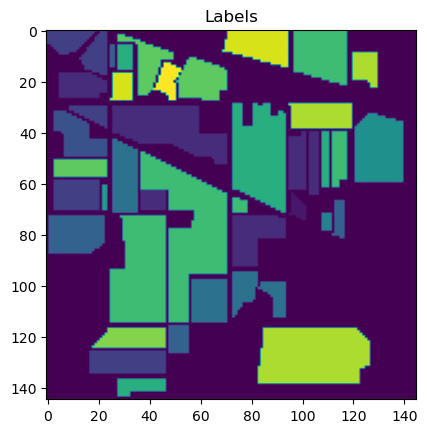

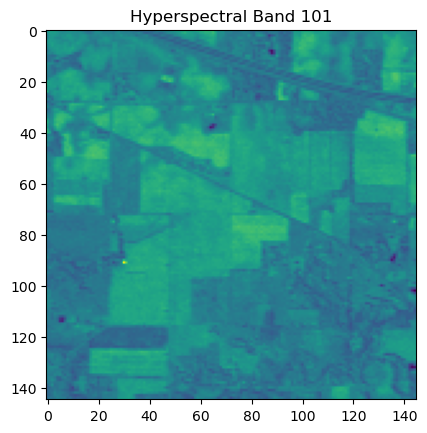

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class '7'
Se


All datasets saved to the 'indices' folder.
(80, 5, 5, 200)
(80, 5, 5, 200)
(10089, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0807, PSNR: 10.9292


Epoch [1/50] Training Loss: 0.0644, PSNR: 11.4747
	[Val]   Batch [1/33] Loss: 0.0488, PSNR: 12.7830
	[Val]   Batch [10/33] Loss: 0.0482, PSNR: 12.4348
	[Val]   Batch [20/33] Loss: 0.0479, PSNR: 12.0225
	[Val]   Batch [30/33] Loss: 0.0464, PSNR: 12.4107
Epoch [1/50] Validation Loss: 0.0485, PSNR: 12.5983

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0482, PSNR: 13.1672


Epoch [2/50] Training Loss: 0.0392, PSNR: 13.6626
	[Val]   Batch [1/33] Loss: 0.0289, PSNR: 15.0491
	[Val]   Batch [10/33] Loss: 0.0284, PSNR: 14.7355
	[Val]   Batch [20/33] Loss: 0.0282, PSNR: 14.3335
	[Val]   Batch [30/33] Loss: 0.0274, PSNR: 14.6948
Epoch [2/50] Validation Loss: 0.0288, PSNR: 14.8635

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0292, PSNR: 14.9760


Epoch [3/50] Training Loss: 0.0230, PSNR: 15.9741
	[Val]   Batch [1/33] Loss: 0.0176, PSNR: 17.2186
	[Val]   Batch [10/33] Loss: 0.0171, PSNR: 16.9487
	[Val]   Batch [20/33] Loss: 0.0168, PSNR: 16.5795
	[Val]   Batch [30/33] Loss: 0.0163, PSNR: 16.9517
Epoch [3/50] Validation Loss: 0.0175, PSNR: 17.0382

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0165, PSNR: 17.1965


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0654
	[Val]   Batch [1/33] Loss: 0.0115, PSNR: 19.0564
	[Val]   Batch [10/33] Loss: 0.0110, PSNR: 18.8413
	[Val]   Batch [20/33] Loss: 0.0108, PSNR: 18.5094
	[Val]   Batch [30/33] Loss: 0.0104, PSNR: 18.8857
Epoch [4/50] Validation Loss: 0.0115, PSNR: 18.8746

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0110, PSNR: 19.2191


Epoch [5/50] Training Loss: 0.0096, PSNR: 19.7242
	[Val]   Batch [1/33] Loss: 0.0083, PSNR: 20.4618
	[Val]   Batch [10/33] Loss: 0.0079, PSNR: 20.3106
	[Val]   Batch [20/33] Loss: 0.0076, PSNR: 20.0216
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.4042
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2847

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0073, PSNR: 21.1478


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0402
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6002
	[Val]   Batch [10/33] Loss: 0.0060, PSNR: 21.5146
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2641
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6524
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4256

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0062, PSNR: 21.8246


Epoch [7/50] Training Loss: 0.0056, PSNR: 22.0714
	[Val]   Batch [1/33] Loss: 0.0052, PSNR: 22.4997
	[Val]   Batch [10/33] Loss: 0.0048, PSNR: 22.4902
	[Val]   Batch [20/33] Loss: 0.0045, PSNR: 22.2911
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.6979
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.3438

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0059, PSNR: 21.7618


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8766
	[Val]   Batch [1/33] Loss: 0.0043, PSNR: 23.3117
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.3748
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.2058
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.6169
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.1657

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0048, PSNR: 23.2321


Epoch [9/50] Training Loss: 0.0039, PSNR: 23.6127
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9748
	[Val]   Batch [10/33] Loss: 0.0033, PSNR: 24.1324
	[Val]   Batch [20/33] Loss: 0.0030, PSNR: 23.9974
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.4502
Epoch [9/50] Validation Loss: 0.0037, PSNR: 23.8705

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0042, PSNR: 23.4364


Epoch [10/50] Training Loss: 0.0034, PSNR: 24.2493
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.5335
	[Val]   Batch [10/33] Loss: 0.0028, PSNR: 24.7869
	[Val]   Batch [20/33] Loss: 0.0026, PSNR: 24.6881
	[Val]   Batch [30/33] Loss: 0.0024, PSNR: 25.1948
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.4822

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0031, PSNR: 24.6010


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.8371
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 24.9875
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.3417
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.2687
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.7749
Epoch [11/50] Validation Loss: 0.0028, PSNR: 24.9949

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0033, PSNR: 24.5114


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.3126
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.4658
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.9013
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.8818
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4366
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5266

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.9905


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.7152
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.0506
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.5745
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.6120
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.1749
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.1596

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.4300


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1308
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.3336
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.8670
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.9250
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.5413
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.4638

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.9423


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.4511
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.7924
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.3287
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.4187
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0060
Epoch [15/50] Validation Loss: 0.0018, PSNR: 26.9161

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.0132


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.8112
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.2182
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7101
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.8178
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.4027
Epoch [16/50] Validation Loss: 0.0017, PSNR: 27.3209

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.1417


Epoch [17/50] Training Loss: 0.0018, PSNR: 27.1199
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.6330
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0898
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.2073
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.8429
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7247

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.0132


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.4685
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.1088
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5157
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6399
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.2761
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.1768

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.6491


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.8191
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5953
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9362
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0783
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7500
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.6278

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.7932


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1140
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7242
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 29.0247
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.1493
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.8235
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.7400

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.7631


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.3730
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.1304
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3781
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.5063
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2286
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1113

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.8263


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.6417
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5490
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7584
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9528
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6460
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5344

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.1756


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8699
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8564
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0287
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2377
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 30.9952
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.8457

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.8325


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0640
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1901
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3490
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6101
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3469
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.1841

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.0814


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.1776
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1370
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3049
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5342
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2291
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.1415

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.9418


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.3835
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4398
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6117
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8952
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.6723
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.4727

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.2089


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5375
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6575
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8390
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1541
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9563
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.7093
Early stopping triggered at epoch 27. No improvement for 3 epochs.


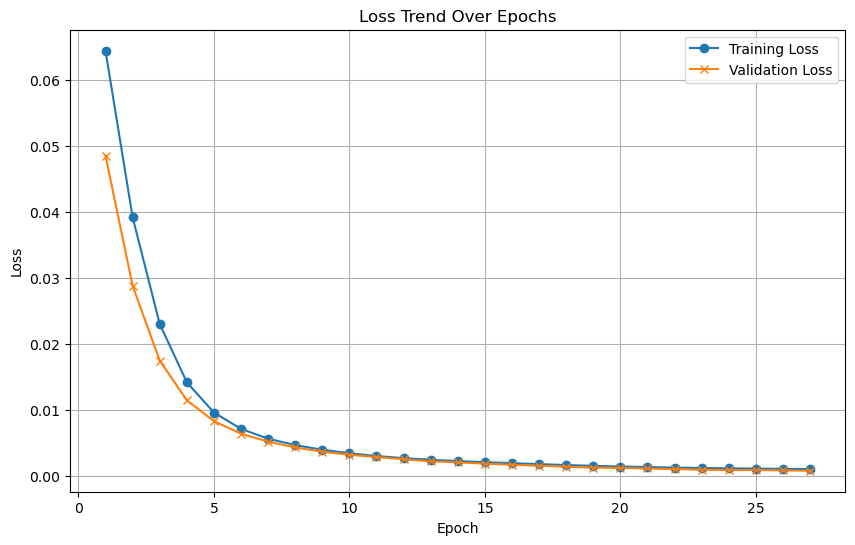

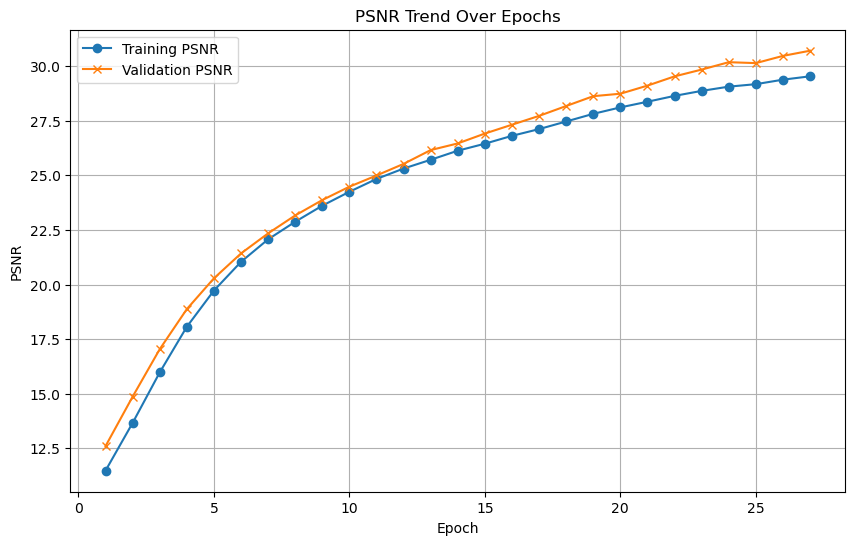

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8122
    Validation Batch [1/1], Loss: 2.7809
Validation Loss: 2.7809, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7809. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7502
    Validation Batch [1/1], Loss: 2.7809
Validation Loss: 2.7809, Validation Accuracy: 6.25%
Validation loss improved from 2.7809 to 2.7809. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7310
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from 2.7809 to 2.7808. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7208
    Validation Batch [1/1], Loss: 2.7808
Validation Loss: 2.7808, Validation Accuracy: 6.25%
Validation loss improved from 2.7808 to 2.7808. Saving model...

LOG: Epoch [5/1000] - 

Epoch [7/1000] completed, Average Training Loss: 2.6790
    Validation Batch [1/1], Loss: 2.7810
Validation Loss: 2.7810, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6617
    Validation Batch [1/1], Loss: 2.7811
Validation Loss: 2.7811, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6444
    Validation Batch [1/1], Loss: 2.7812
Validation Loss: 2.7812, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6322
    Validation Batch [1/1], Loss: 2.7813
Validation Loss: 2.7813, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6191
    Validation Batch

    Validation Batch [1/1], Loss: 2.7823
Validation Loss: 2.7823, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5402
    Validation Batch [1/1], Loss: 2.7824
Validation Loss: 2.7824, Validation Accuracy: 5.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5184
    Validation Batch [1/1], Loss: 2.7824
Validation Loss: 2.7824, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5444
    Validation Batch [1/1], Loss: 2.7824
Validation Loss: 2.7824, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.5190
    Validation Batch [1/1], Loss: 2.7823
Validation Loss: 2.7823, Va

Epoch [32/1000] completed, Average Training Loss: 2.3872
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 10.00%
Validation loss improved from 2.7774 to 2.7755. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.3919
    Validation Batch [1/1], Loss: 2.7739
Validation Loss: 2.7739, Validation Accuracy: 10.00%
Validation loss improved from 2.7755 to 2.7739. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.3874
    Validation Batch [1/1], Loss: 2.7721
Validation Loss: 2.7721, Validation Accuracy: 10.00%
Validation loss improved from 2.7739 to 2.7721. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.3545
    Validation Batch [1/1], Loss: 2.7691
Validation Loss: 2.7691, Validation Accuracy: 10.00%
Validation loss improved from 2.7721 to 2.7691. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [3

Epoch [46/1000] completed, Average Training Loss: 2.2573
    Validation Batch [1/1], Loss: 2.6945
Validation Loss: 2.6945, Validation Accuracy: 26.25%
Validation loss improved from 2.7064 to 2.6945. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2546
    Validation Batch [1/1], Loss: 2.6818
Validation Loss: 2.6818, Validation Accuracy: 30.00%
Validation loss improved from 2.6945 to 2.6818. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2522
    Validation Batch [1/1], Loss: 2.6700
Validation Loss: 2.6700, Validation Accuracy: 30.00%
Validation loss improved from 2.6818 to 2.6700. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2424
    Validation Batch [1/1], Loss: 2.6568
Validation Loss: 2.6568, Validation Accuracy: 30.00%
Validation loss improved from 2.6700 to 2.6568. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [5

Epoch [60/1000] completed, Average Training Loss: 2.1058
    Validation Batch [1/1], Loss: 2.5428
Validation Loss: 2.5428, Validation Accuracy: 33.75%
Validation loss improved from 2.5431 to 2.5428. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.0922
    Validation Batch [1/1], Loss: 2.5358
Validation Loss: 2.5358, Validation Accuracy: 38.75%
Validation loss improved from 2.5428 to 2.5358. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.0304
    Validation Batch [1/1], Loss: 2.5170
Validation Loss: 2.5170, Validation Accuracy: 38.75%
Validation loss improved from 2.5358 to 2.5170. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.1251
    Validation Batch [1/1], Loss: 2.4873
Validation Loss: 2.4873, Validation Accuracy: 36.25%
Validation loss improved from 2.5170 to 2.4873. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [6

Epoch [74/1000] completed, Average Training Loss: 1.9894
    Validation Batch [1/1], Loss: 2.4113
Validation Loss: 2.4113, Validation Accuracy: 31.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9373
    Validation Batch [1/1], Loss: 2.3942
Validation Loss: 2.3942, Validation Accuracy: 40.00%
Validation loss improved from 2.4011 to 2.3942. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9188
    Validation Batch [1/1], Loss: 2.3973
Validation Loss: 2.3973, Validation Accuracy: 35.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9472
    Validation Batch [1/1], Loss: 2.4015
Validation Loss: 2.4015, Validation Accuracy: 35.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.9

    Validation Batch [1/1], Loss: 2.3047
Validation Loss: 2.3047, Validation Accuracy: 41.25%
Validation loss improved from 2.3252 to 2.3047. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.8239
    Validation Batch [1/1], Loss: 2.2864
Validation Loss: 2.2864, Validation Accuracy: 42.50%
Validation loss improved from 2.3047 to 2.2864. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.8535
    Validation Batch [1/1], Loss: 2.3141
Validation Loss: 2.3141, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.8841
    Validation Batch [1/1], Loss: 2.3043
Validation Loss: 2.3043, Validation Accuracy: 36.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.8167
    Validation Batch [1/1], Loss: 2.28

Epoch [106/1000] completed, Average Training Loss: 1.6551
    Validation Batch [1/1], Loss: 2.2134
Validation Loss: 2.2134, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.6635
    Validation Batch [1/1], Loss: 2.2107
Validation Loss: 2.2107, Validation Accuracy: 41.25%
Validation loss improved from 2.2122 to 2.2107. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.6082
    Validation Batch [1/1], Loss: 2.2078
Validation Loss: 2.2078, Validation Accuracy: 43.75%
Validation loss improved from 2.2107 to 2.2078. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.6499
    Validation Batch [1/1], Loss: 2.2267
Validation Loss: 2.2267, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Av

    Validation Batch [1/1], Loss: 2.1662
Validation Loss: 2.1662, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.5829
    Validation Batch [1/1], Loss: 2.2084
Validation Loss: 2.2084, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.5265
    Validation Batch [1/1], Loss: 2.2427
Validation Loss: 2.2427, Validation Accuracy: 37.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5333
    Validation Batch [1/1], Loss: 2.1844
Validation Loss: 2.1844, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.5078
    Validation Batch [1/1], Loss: 2.1512
Validation Loss: 2.

    Validation Batch [1/1], Loss: 2.1021
Validation Loss: 2.1021, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.4035
    Validation Batch [1/1], Loss: 2.0942
Validation Loss: 2.0942, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.4343
    Validation Batch [1/1], Loss: 2.0878
Validation Loss: 2.0878, Validation Accuracy: 48.75%
Validation loss improved from 2.0897 to 2.0878. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.4554
    Validation Batch [1/1], Loss: 2.0873
Validation Loss: 2.0873, Validation Accuracy: 47.50%
Validation loss improved from 2.0878 to 2.0873. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.4215
    Validation Batch [1/1], Lo

Epoch [148/1000] completed, Average Training Loss: 1.3256
    Validation Batch [1/1], Loss: 2.0856
Validation Loss: 2.0856, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.3363
    Validation Batch [1/1], Loss: 2.0907
Validation Loss: 2.0907, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.2887
    Validation Batch [1/1], Loss: 2.0378
Validation Loss: 2.0378, Validation Accuracy: 52.50%
Validation loss improved from 2.0589 to 2.0378. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.2543
    Validation Batch [1/1], Loss: 2.0328
Validation Loss: 2.0328, Validation Accuracy: 48.75%
Validation loss improved from 2.0378 to 2.0328. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Av

Epoch [164/1000] completed, Average Training Loss: 1.2180
    Validation Batch [1/1], Loss: 1.9851
Validation Loss: 1.9851, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.1895
    Validation Batch [1/1], Loss: 2.0062
Validation Loss: 2.0062, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.1506
    Validation Batch [1/1], Loss: 2.0158
Validation Loss: 2.0158, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.1928
    Validation Batch [1/1], Loss: 2.0110
Validation Loss: 2.0110, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.1506
  

Epoch [176/1000] completed, Average Training Loss: 1.0762
    Validation Batch [1/1], Loss: 1.9704
Validation Loss: 1.9704, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.0824
    Validation Batch [1/1], Loss: 1.9463
Validation Loss: 1.9463, Validation Accuracy: 51.25%
Validation loss improved from 1.9688 to 1.9463. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.1514
    Validation Batch [1/1], Loss: 1.9570
Validation Loss: 1.9570, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.1066
    Validation Batch [1/1], Loss: 1.9623
Validation Loss: 1.9623, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training

    Validation Batch [1/1], Loss: 1.9375
Validation Loss: 1.9375, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.9675
    Validation Batch [1/1], Loss: 1.9228
Validation Loss: 1.9228, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.9977
    Validation Batch [1/1], Loss: 1.9360
Validation Loss: 1.9360, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.9658
    Validation Batch [1/1], Loss: 1.8871
Validation Loss: 1.8871, Validation Accuracy: 52.50%
Validation loss improved from 1.9219 to 1.8871. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.9209
    Validation Batch [1/1], Loss: 1.9166
Vali

Epoch [204/1000] completed, Average Training Loss: 0.9105
    Validation Batch [1/1], Loss: 1.8885
Validation Loss: 1.8885, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.8415
    Validation Batch [1/1], Loss: 1.8558
Validation Loss: 1.8558, Validation Accuracy: 57.50%
Validation loss improved from 1.8766 to 1.8558. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.8857
    Validation Batch [1/1], Loss: 1.8663
Validation Loss: 1.8663, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.8804
    Validation Batch [1/1], Loss: 1.8895
Validation Loss: 1.8895, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.8139
Validation Loss: 1.8139, Validation Accuracy: 52.50%
Validation loss improved from 1.8173 to 1.8139. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.7111
    Validation Batch [1/1], Loss: 1.8355
Validation Loss: 1.8355, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.8011
    Validation Batch [1/1], Loss: 1.8443
Validation Loss: 1.8443, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.7472
    Validation Batch [1/1], Loss: 1.9200
Validation Loss: 1.9200, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.7444
    Validation Batch [1/1], Loss: 1.8410
Vali

Epoch [231/1000] completed, Average Training Loss: 0.7239
    Validation Batch [1/1], Loss: 1.8055
Validation Loss: 1.8055, Validation Accuracy: 57.50%
Validation loss improved from 1.8139 to 1.8055. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7205
    Validation Batch [1/1], Loss: 1.8223
Validation Loss: 1.8223, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7116
    Validation Batch [1/1], Loss: 1.8142
Validation Loss: 1.8142, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6847
    Validation Batch [1/1], Loss: 1.8133
Validation Loss: 1.8133, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.8204
Validation Loss: 1.8204, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.7151
    Validation Batch [1/1], Loss: 1.8433
Validation Loss: 1.8433, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.5678
    Validation Batch [1/1], Loss: 1.8155
Validation Loss: 1.8155, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.5952
    Validation Batch [1/1], Loss: 1.8047
Validation Loss: 1.8047, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.5936
    Validation Batch [1/1], Loss: 1.7783
Validation Loss: 

    Validation Batch [1/1], Loss: 1.7545
Validation Loss: 1.7545, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5230
    Validation Batch [1/1], Loss: 1.8066
Validation Loss: 1.8066, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.5409
    Validation Batch [1/1], Loss: 1.8945
Validation Loss: 1.8945, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.5048
    Validation Batch [1/1], Loss: 1.8298
Validation Loss: 1.8298, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.4677
    Validation Batch [1/1], Loss: 1.7423
Validation Loss: 1.

Epoch [278/1000] completed, Average Training Loss: 0.5148
    Validation Batch [1/1], Loss: 1.7056
Validation Loss: 1.7056, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4792
    Validation Batch [1/1], Loss: 1.7451
Validation Loss: 1.7451, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.4486
    Validation Batch [1/1], Loss: 1.7547
Validation Loss: 1.7547, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4862
    Validation Batch [1/1], Loss: 1.7099
Validation Loss: 1.7099, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4204
  

Epoch [293/1000] completed, Average Training Loss: 0.3829
    Validation Batch [1/1], Loss: 1.6907
Validation Loss: 1.6907, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.4581
    Validation Batch [1/1], Loss: 1.7023
Validation Loss: 1.7023, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.3643
    Validation Batch [1/1], Loss: 1.7502
Validation Loss: 1.7502, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.3821
    Validation Batch [1/1], Loss: 1.7487
Validation Loss: 1.7487, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.361


LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3586
    Validation Batch [1/1], Loss: 1.6590
Validation Loss: 1.6590, Validation Accuracy: 61.25%
Validation loss improved from 1.6601 to 1.6590. Saving model...

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3822
    Validation Batch [1/1], Loss: 1.6737
Validation Loss: 1.6737, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3317
    Validation Batch [1/1], Loss: 1.6930
Validation Loss: 1.6930, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3606
    Validation Batch [1/1], Loss: 1.6981
Validation Loss: 1.6981, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [309/1000] - Training
Epoch [309/

Epoch [324/1000] completed, Average Training Loss: 0.2659
    Validation Batch [1/1], Loss: 1.6464
Validation Loss: 1.6464, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.2847
    Validation Batch [1/1], Loss: 1.6379
Validation Loss: 1.6379, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.3241
    Validation Batch [1/1], Loss: 1.6523
Validation Loss: 1.6523, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3284
    Validation Batch [1/1], Loss: 1.6390
Validation Loss: 1.6390, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3206
  

Epoch [335/1000] completed, Average Training Loss: 0.3076
    Validation Batch [1/1], Loss: 1.6252
Validation Loss: 1.6252, Validation Accuracy: 61.25%
Validation loss improved from 1.6260 to 1.6252. Saving model...

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.2624
    Validation Batch [1/1], Loss: 1.6522
Validation Loss: 1.6522, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3023
    Validation Batch [1/1], Loss: 1.6188
Validation Loss: 1.6188, Validation Accuracy: 61.25%
Validation loss improved from 1.6252 to 1.6188. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2541
    Validation Batch [1/1], Loss: 1.6464
Validation Loss: 1.6464, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Av

Epoch [354/1000] completed, Average Training Loss: 0.2547
    Validation Batch [1/1], Loss: 1.6103
Validation Loss: 1.6103, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2425
    Validation Batch [1/1], Loss: 1.6518
Validation Loss: 1.6518, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2378
    Validation Batch [1/1], Loss: 1.6728
Validation Loss: 1.6728, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2438
    Validation Batch [1/1], Loss: 1.7521
Validation Loss: 1.7521, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2227
  

    Validation Batch [1/1], Loss: 1.7140
Validation Loss: 1.7140, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2692
    Validation Batch [1/1], Loss: 1.6717
Validation Loss: 1.6717, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2349
    Validation Batch [1/1], Loss: 1.6298
Validation Loss: 1.6298, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1960
    Validation Batch [1/1], Loss: 1.6774
Validation Loss: 1.6774, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2394
    Validation Batch [1/1], Loss: 1.6706
Validation Loss

    Validation Batch [1/1], Loss: 1.6467
Validation Loss: 1.6467, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2017
    Validation Batch [1/1], Loss: 1.6253
Validation Loss: 1.6253, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.1888
    Validation Batch [1/1], Loss: 1.5810
Validation Loss: 1.5810, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.2030
    Validation Batch [1/1], Loss: 1.5676
Validation Loss: 1.5676, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2613
    Validation Batch [1/1], Loss: 1.6307
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.6248
Validation Loss: 1.6248, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2205
    Validation Batch [1/1], Loss: 1.6251
Validation Loss: 1.6251, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1960
    Validation Batch [1/1], Loss: 1.6017
Validation Loss: 1.6017, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.2094
    Validation Batch [1/1], Loss: 1.6160
Validation Loss: 1.6160, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1718
    Validation Batch [1/1], Loss: 1.6324
Validation Loss

    Validation Batch [1/1], Loss: 1.5908
Validation Loss: 1.5908, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1747
    Validation Batch [1/1], Loss: 1.5742
Validation Loss: 1.5742, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1724
    Validation Batch [1/1], Loss: 1.6228
Validation Loss: 1.6228, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1806
    Validation Batch [1/1], Loss: 1.6317
Validation Loss: 1.6317, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1459
    Validation Batch [1/1], Loss: 1.5819
Validation Loss

Epoch [423/1000] completed, Average Training Loss: 0.1815
    Validation Batch [1/1], Loss: 1.5607
Validation Loss: 1.5607, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1597
    Validation Batch [1/1], Loss: 1.5969
Validation Loss: 1.5969, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1395
    Validation Batch [1/1], Loss: 1.6741
Validation Loss: 1.6741, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1453
    Validation Batch [1/1], Loss: 1.6869
Validation Loss: 1.6869, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.171

    Validation Batch [1/1], Loss: 1.7100
Validation Loss: 1.7100, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1227
    Validation Batch [1/1], Loss: 1.7086
Validation Loss: 1.7086, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1582
    Validation Batch [1/1], Loss: 1.6317
Validation Loss: 1.6317, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1175
    Validation Batch [1/1], Loss: 1.5941
Validation Loss: 1.5941, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1490
    Validation Batch [1/1], Loss: 1.5872
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.5841
Validation Loss: 1.5841, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1671
    Validation Batch [1/1], Loss: 1.5871
Validation Loss: 1.5871, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1419
    Validation Batch [1/1], Loss: 1.5819
Validation Loss: 1.5819, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1437
    Validation Batch [1/1], Loss: 1.5586
Validation Loss: 1.5586, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1224
    Validation Batch [1/1], Loss: 1.5718
Validation Loss

Epoch [472/1000] completed, Average Training Loss: 0.1279
    Validation Batch [1/1], Loss: 1.5472
Validation Loss: 1.5472, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1292
    Validation Batch [1/1], Loss: 1.5942
Validation Loss: 1.5942, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 1.6049
Validation Loss: 1.6049, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1214
    Validation Batch [1/1], Loss: 1.5791
Validation Loss: 1.5791, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1184
  

Epoch [480/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 1.5723
Validation Loss: 1.5723, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1041
    Validation Batch [1/1], Loss: 1.6325
Validation Loss: 1.6325, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.1137
    Validation Batch [1/1], Loss: 1.6249
Validation Loss: 1.6249, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.1228
    Validation Batch [1/1], Loss: 1.5891
Validation Loss: 1.5891, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.122

Epoch [501/1000] completed, Average Training Loss: 0.1091
    Validation Batch [1/1], Loss: 1.5736
Validation Loss: 1.5736, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 1.6422
Validation Loss: 1.6422, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 1.6330
Validation Loss: 1.6330, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0967
    Validation Batch [1/1], Loss: 1.5574
Validation Loss: 1.5574, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.120

Epoch [511/1000] completed, Average Training Loss: 0.0978
    Validation Batch [1/1], Loss: 1.5566
Validation Loss: 1.5566, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.1113
    Validation Batch [1/1], Loss: 1.5853
Validation Loss: 1.5853, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0928
    Validation Batch [1/1], Loss: 1.6160
Validation Loss: 1.6160, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.1106
    Validation Batch [1/1], Loss: 1.5886
Validation Loss: 1.5886, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.104

Epoch [530/1000] completed, Average Training Loss: 0.0962
    Validation Batch [1/1], Loss: 1.6370
Validation Loss: 1.6370, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 1.6866
Validation Loss: 1.6866, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0996
    Validation Batch [1/1], Loss: 1.6933
Validation Loss: 1.6933, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0961
    Validation Batch [1/1], Loss: 1.6723
Validation Loss: 1.6723, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.082

Epoch [541/1000] completed, Average Training Loss: 0.0864
    Validation Batch [1/1], Loss: 1.7567
Validation Loss: 1.7567, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0785
    Validation Batch [1/1], Loss: 1.7171
Validation Loss: 1.7171, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 1.6485
Validation Loss: 1.6485, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0905
    Validation Batch [1/1], Loss: 1.6019
Validation Loss: 1.6019, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.081

Epoch [559/1000] completed, Average Training Loss: 0.0759
    Validation Batch [1/1], Loss: 1.8134
Validation Loss: 1.8134, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0810
    Validation Batch [1/1], Loss: 1.7433
Validation Loss: 1.7433, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0840
    Validation Batch [1/1], Loss: 1.6383
Validation Loss: 1.6383, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 1.6174
Validation Loss: 1.6174, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.089

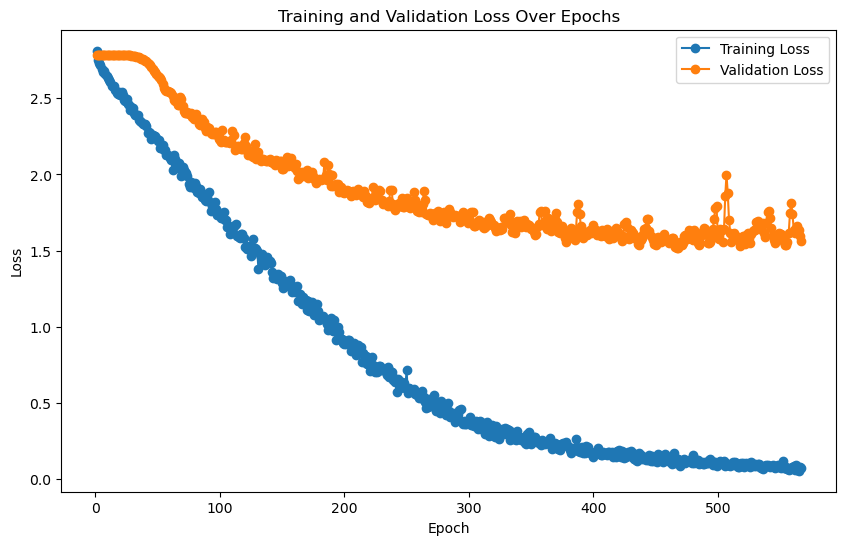

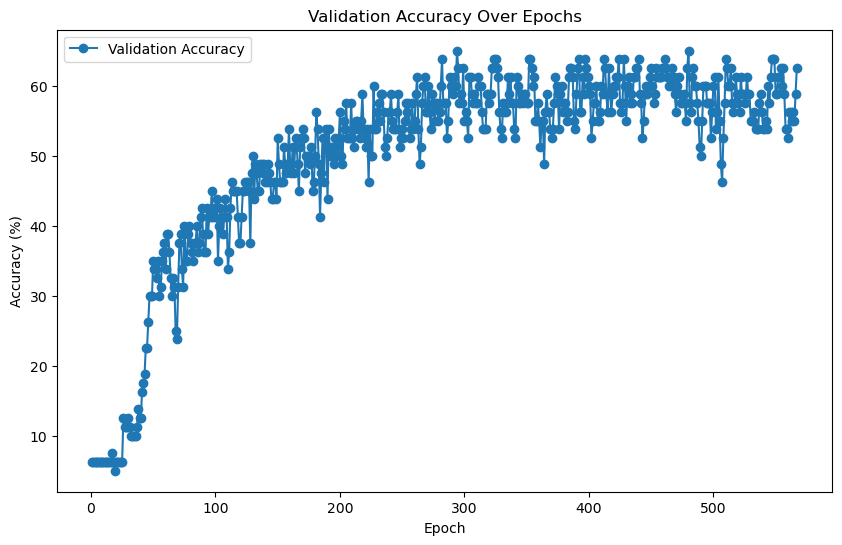


Evaluating on the test set...
    Test Batch [1/40], Loss: 2.2951

Final Test Loss: 1.7694, Test Accuracy: 45.52%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10089, 64), Test labels shape: (10089,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00         5
           3       0.29      0.40      0.33         5
           4       0.60      0.60      0.60         5
           5       0.17      0.20      0.18         5
           6       0.38      0.60      0.46         5
           7       0.43      0.60      0.50         5
           8       0.57      0.80

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10089, 64)
Test labels shape: (10089,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9022  |  Val Loss: 2.7492
Validation loss improved from inf to 2.7492.
[Epoch 2/1000] Train Loss: 2.7351  |  Val Loss: 2.6791
Validation loss improved from 2.7492 to 2.6791.
[Epoch 3/1000] Train Loss: 2.6490  |  Val Loss: 2.6363
Validation loss improved from 2.6791 to 2.6363.
[Epoch 4/1000] Train Loss: 2.5964  |  Val Loss: 2.6024
Validation loss improved from 2.6363 to 2.6024.
[Epoch 5/1000] Train Loss: 2.5507  |  Val Loss: 2.5624
Validation loss improved from 2.6024 to 2.5624.
[Epoch 6/1000] Train Loss: 2.4952  |  Val Loss: 2.5192
Validation loss improved from 2.5624 to 2.5192.
[Epoch 7/1000] Train Loss: 2.4468  |  Val Loss: 2.4773
Validation loss improved from 2.5192 to 2.4773.
[Epoch 8/1000] Train Loss: 2.3893  |  Val Loss: 2.4382
Validation loss improved from 2.4773 to 2.4382.
[Epoch 9/1000] Train Loss: 2.3387  |  Val Loss: 2.4016
Validation loss improved from 2.4382 to 2.4016.
[Epoch 10/1000] Train Loss: 2.2875  |  Val Loss: 2.3670
Validation loss impr

[Epoch 18/1000] Train Loss: 1.9351  |  Val Loss: 2.1357
Validation loss improved from 2.1656 to 2.1357.
[Epoch 19/1000] Train Loss: 1.8932  |  Val Loss: 2.1085
Validation loss improved from 2.1357 to 2.1085.
[Epoch 20/1000] Train Loss: 1.8509  |  Val Loss: 2.0832
Validation loss improved from 2.1085 to 2.0832.
[Epoch 21/1000] Train Loss: 1.8072  |  Val Loss: 2.0575
Validation loss improved from 2.0832 to 2.0575.
[Epoch 22/1000] Train Loss: 1.7719  |  Val Loss: 2.0332
Validation loss improved from 2.0575 to 2.0332.
[Epoch 23/1000] Train Loss: 1.7295  |  Val Loss: 2.0097
Validation loss improved from 2.0332 to 2.0097.
[Epoch 24/1000] Train Loss: 1.6954  |  Val Loss: 1.9910
Validation loss improved from 2.0097 to 1.9910.
[Epoch 25/1000] Train Loss: 1.6647  |  Val Loss: 1.9741
Validation loss improved from 1.9910 to 1.9741.
[Epoch 26/1000] Train Loss: 1.6355  |  Val Loss: 1.9549
Validation loss improved from 1.9741 to 1.9549.
[Epoch 27/1000] Train Loss: 1.6037  |  Val Loss: 1.9254
Validati

[Epoch 32/1000] Train Loss: 1.4522  |  Val Loss: 1.8634
Validation loss improved from 1.8693 to 1.8634.
[Epoch 33/1000] Train Loss: 1.4209  |  Val Loss: 1.8531
Validation loss improved from 1.8634 to 1.8531.
[Epoch 34/1000] Train Loss: 1.3924  |  Val Loss: 1.8360
Validation loss improved from 1.8531 to 1.8360.
[Epoch 35/1000] Train Loss: 1.3593  |  Val Loss: 1.8218
Validation loss improved from 1.8360 to 1.8218.
[Epoch 36/1000] Train Loss: 1.3312  |  Val Loss: 1.8205
Validation loss improved from 1.8218 to 1.8205.
[Epoch 37/1000] Train Loss: 1.3132  |  Val Loss: 1.8279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 1.3091  |  Val Loss: 1.8220
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 1.2721  |  Val Loss: 1.7943
Validation loss improved from 1.8205 to 1.7943.
[Epoch 40/1000] Train Loss: 1.2351  |  Val Loss: 1.7813
Validation loss improved from 1.7943 to 1.7813.
[Epoch 41/1000] Train Loss: 1.2159  |  Val Loss: 1.7

[Epoch 44/1000] Train Loss: 1.1664  |  Val Loss: 1.7751
Validation loss improved from 1.7758 to 1.7751.
[Epoch 45/1000] Train Loss: 1.1474  |  Val Loss: 1.7922
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 1.1454  |  Val Loss: 1.7939
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 47/1000] Train Loss: 1.1244  |  Val Loss: 1.7751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 48/1000] Train Loss: 1.1005  |  Val Loss: 1.7709
Validation loss improved from 1.7751 to 1.7709.
[Epoch 49/1000] Train Loss: 1.0884  |  Val Loss: 1.7696
Validation loss improved from 1.7709 to 1.7696.
[Epoch 50/1000] Train Loss: 1.0800  |  Val Loss: 1.7671
Validation loss improved from 1.7696 to 1.7671.
[Epoch 51/1000] Train Loss: 1.0611  |  Val Loss: 1.7726
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 52/1000] Train Loss: 1.0476  |  Val Loss: 1.7824
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 53/1000] Train Loss: 1.0408

[Epoch 63/1000] Train Loss: 0.8974  |  Val Loss: 1.7775
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 0.8916  |  Val Loss: 1.7870
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 65/1000] Train Loss: 0.8810  |  Val Loss: 1.7904
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 66/1000] Train Loss: 0.8691  |  Val Loss: 1.7979
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 67/1000] Train Loss: 0.8607  |  Val Loss: 1.8133
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 68/1000] Train Loss: 0.8585  |  Val Loss: 1.8117
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 69/1000] Train Loss: 0.8446  |  Val Loss: 1.7994
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 70/1000] Train Loss: 0.8254  |  Val Loss: 1.7979
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 71/1000] Train Loss: 0.8263  |  Val Loss: 1.8187
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 72

[Epoch 73/1000] Train Loss: 0.8134  |  Val Loss: 1.8259
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 74/1000] Train Loss: 0.7984  |  Val Loss: 1.8179
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 75/1000] Train Loss: 0.7839  |  Val Loss: 1.8111
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 76/1000] Train Loss: 0.7760  |  Val Loss: 1.8185
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 77/1000] Train Loss: 0.7698  |  Val Loss: 1.8362
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 78/1000] Train Loss: 0.7660  |  Val Loss: 1.8561
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 79/1000] Train Loss: 0.7571  |  Val Loss: 1.8587
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 80/1000] Train Loss: 0.7464  |  Val Loss: 1.8565
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 81/1000] Train Loss: 0.7317  |  Val Loss: 1.8593
!! Validation loss did NOT improve !! Patience: 20/100
[

[Epoch 85/1000] Train Loss: 0.7152  |  Val Loss: 1.9148
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 86/1000] Train Loss: 0.7109  |  Val Loss: 1.9082
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 87/1000] Train Loss: 0.6954  |  Val Loss: 1.8853
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 88/1000] Train Loss: 0.6807  |  Val Loss: 1.8815
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 89/1000] Train Loss: 0.6870  |  Val Loss: 1.8881
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 90/1000] Train Loss: 0.6783  |  Val Loss: 1.8949
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 91/1000] Train Loss: 0.6708  |  Val Loss: 1.9189
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 92/1000] Train Loss: 0.6663  |  Val Loss: 1.9377
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 93/1000] Train Loss: 0.6544  |  Val Loss: 1.9173
!! Validation loss did NOT improve !! Patience: 32/100
[

[Epoch 104/1000] Train Loss: 0.5901  |  Val Loss: 2.0021
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 105/1000] Train Loss: 0.5757  |  Val Loss: 2.0610
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 106/1000] Train Loss: 0.5838  |  Val Loss: 2.0966
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 107/1000] Train Loss: 0.5962  |  Val Loss: 2.0949
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 108/1000] Train Loss: 0.5910  |  Val Loss: 2.0578
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 109/1000] Train Loss: 0.5846  |  Val Loss: 2.0265
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 110/1000] Train Loss: 0.5765  |  Val Loss: 2.0159
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 111/1000] Train Loss: 0.5702  |  Val Loss: 2.0309
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 112/1000] Train Loss: 0.5758  |  Val Loss: 2.0717
!! Validation loss did NOT improve !! Patience:

[Epoch 114/1000] Train Loss: 0.5421  |  Val Loss: 2.1092
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 115/1000] Train Loss: 0.5385  |  Val Loss: 2.0896
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 116/1000] Train Loss: 0.5282  |  Val Loss: 2.0616
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 117/1000] Train Loss: 0.5389  |  Val Loss: 2.0653
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 118/1000] Train Loss: 0.5463  |  Val Loss: 2.0685
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 119/1000] Train Loss: 0.5395  |  Val Loss: 2.0808
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 120/1000] Train Loss: 0.5254  |  Val Loss: 2.1156
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 121/1000] Train Loss: 0.5175  |  Val Loss: 2.1542
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 122/1000] Train Loss: 0.5157  |  Val Loss: 2.1547
!! Validation loss did NOT improve !! Patience:

[Epoch 126/1000] Train Loss: 0.5260  |  Val Loss: 2.1510
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 127/1000] Train Loss: 0.4885  |  Val Loss: 2.1827
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 128/1000] Train Loss: 0.4798  |  Val Loss: 2.1892
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 129/1000] Train Loss: 0.4779  |  Val Loss: 2.1615
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 130/1000] Train Loss: 0.4741  |  Val Loss: 2.1258
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 131/1000] Train Loss: 0.4684  |  Val Loss: 2.1152
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 132/1000] Train Loss: 0.4622  |  Val Loss: 2.1327
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 133/1000] Train Loss: 0.4597  |  Val Loss: 2.1620
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 134/1000] Train Loss: 0.4629  |  Val Loss: 2.1877
!! Validation loss did NOT improve !! Patience:

[Epoch 143/1000] Train Loss: 0.4141  |  Val Loss: 2.2384
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 144/1000] Train Loss: 0.4224  |  Val Loss: 2.2446
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 145/1000] Train Loss: 0.4237  |  Val Loss: 2.2630
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 146/1000] Train Loss: 0.4079  |  Val Loss: 2.2884
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 147/1000] Train Loss: 0.4130  |  Val Loss: 2.3001
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 148/1000] Train Loss: 0.4284  |  Val Loss: 2.2881
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 149/1000] Train Loss: 0.4136  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 150/1000] Train Loss: 0.4016  |  Val Loss: 2.2607
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 151/1000] Train Loss: 0.3995  |  Val Loss: 2.2830
!! Validation loss did NOT improve !! Patience:

[Epoch 153/1000] Train Loss: 0.4027  |  Val Loss: 2.3174
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 154/1000] Train Loss: 0.3982  |  Val Loss: 2.3124
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 155/1000] Train Loss: 0.3894  |  Val Loss: 2.3113
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 156/1000] Train Loss: 0.3877  |  Val Loss: 2.3031
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 157/1000] Train Loss: 0.3897  |  Val Loss: 2.2825
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 158/1000] Train Loss: 0.3861  |  Val Loss: 2.2679
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 159/1000] Train Loss: 0.3791  |  Val Loss: 2.2859
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 160/1000] Train Loss: 0.3641  |  Val Loss: 2.3129
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 161/1000] Train Loss: 0.3632  |  Val Loss: 2.3460
!! Validation loss did NOT improve !! Patience:

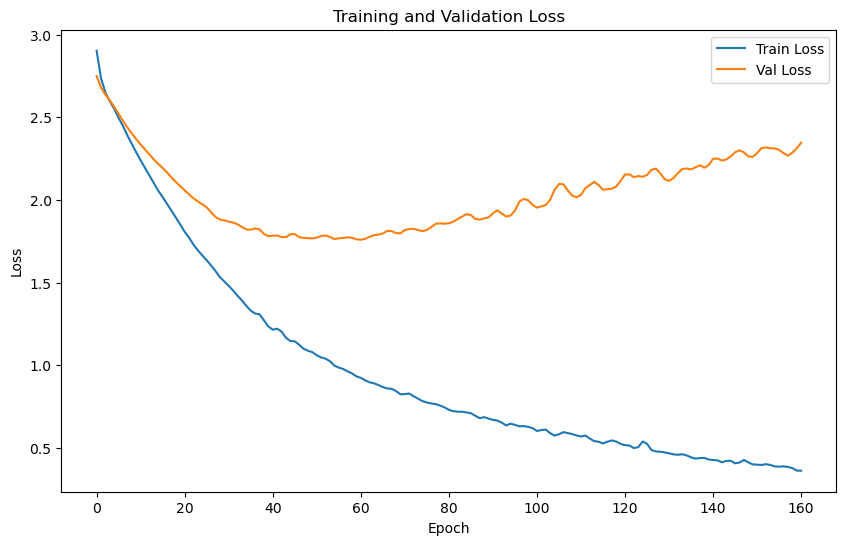

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.4330 | Test Accuracy: 37.32%


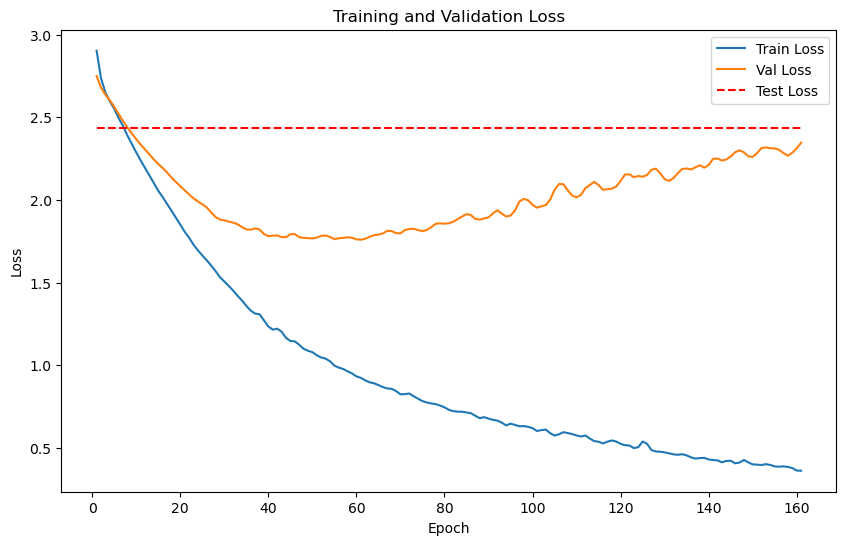

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.5337
Epoch [1/2000], Avg Train Loss: 9.5337
Epoch [1/2000], Avg Val Loss: 5.8160
Validation loss improved from inf to 5.8160. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.1428
Epoch [2/2000], Avg Train Loss: 9.1428
Epoch [2/2000], Avg Val Loss: 5.7595
Validation loss improved from 5.8160 to 5.7595. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.9724
Epoch [3/2000], Avg Train Loss: 8.9724
Epoch [3/2000], Avg Val Loss: 5.7037
Validation loss improved from 5.7595 to 5.7037. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1011
Epoch [4/2000], Avg Train Loss: 9.1011
Epoch [4/2000], Avg Val Loss: 5.6495
Validation loss improved from 5.7037 to 5.6495. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7716
Epoch [5/2000], Avg Train Loss: 8.7716
Epoch [5/2000], Avg Val Loss: 5.5963
Validation loss improved from 5.6495 to 5.5963. Saving mode

Epoch [16/2000], Avg Val Loss: 5.0719
Validation loss improved from 5.1154 to 5.0719. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.9998
Epoch [17/2000], Avg Train Loss: 7.9998
Epoch [17/2000], Avg Val Loss: 5.0296
Validation loss improved from 5.0719 to 5.0296. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 8.1917
Epoch [18/2000], Avg Train Loss: 8.1917
Epoch [18/2000], Avg Val Loss: 4.9884
Validation loss improved from 5.0296 to 4.9884. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.9706
Epoch [19/2000], Avg Train Loss: 7.9706
Epoch [19/2000], Avg Val Loss: 4.9481
Validation loss improved from 4.9884 to 4.9481. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.9732
Epoch [20/2000], Avg Train Loss: 7.9732
Epoch [20/2000], Avg Val Loss: 4.9088
Validation loss improved from 4.9481 to 4.9088. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Trai

Epoch [24/2000], Avg Val Loss: 4.7611
Validation loss improved from 4.7967 to 4.7611. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.6228
Epoch [25/2000], Avg Train Loss: 7.6228
Epoch [25/2000], Avg Val Loss: 4.7264
Validation loss improved from 4.7611 to 4.7264. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.5477
Epoch [26/2000], Avg Train Loss: 7.5477
Epoch [26/2000], Avg Val Loss: 4.6926
Validation loss improved from 4.7264 to 4.6926. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.5485
Epoch [27/2000], Avg Train Loss: 7.5485
Epoch [27/2000], Avg Val Loss: 4.6598
Validation loss improved from 4.6926 to 4.6598. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.5361
Epoch [28/2000], Avg Train Loss: 7.5361
Epoch [28/2000], Avg Val Loss: 4.6277
Validation loss improved from 4.6598 to 4.6277. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.2643
Epoch [50/2000], Avg Train Loss: 6.2643
Epoch [50/2000], Avg Val Loss: 4.1131
Validation loss improved from 4.1296 to 4.1131. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.9874
Epoch [51/2000], Avg Train Loss: 5.9874
Epoch [51/2000], Avg Val Loss: 4.0971
Validation loss improved from 4.1131 to 4.0971. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0220
Epoch [52/2000], Avg Train Loss: 6.0220
Epoch [52/2000], Avg Val Loss: 4.0815
Validation loss improved from 4.0971 to 4.0815. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.2556
Epoch [53/2000], Avg Train Loss: 6.2556
Epoch [53/2000], Avg Val Loss: 4.0664
Validation loss improved from 4.0815 to 4.0664. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.0407
Epoch [54/2000], Avg Train Loss: 6.0407
Epoch [54/2000], Avg Val Loss: 4.0518
Validation loss improved from 4.0664 to 4.

Epoch [66/2000], Avg Val Loss: 3.9111
Validation loss improved from 3.9206 to 3.9111. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.7437
Epoch [67/2000], Avg Train Loss: 5.7437
Epoch [67/2000], Avg Val Loss: 3.9019
Validation loss improved from 3.9111 to 3.9019. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 5.6251
Epoch [68/2000], Avg Train Loss: 5.6251
Epoch [68/2000], Avg Val Loss: 3.8930
Validation loss improved from 3.9019 to 3.8930. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.3672
Epoch [69/2000], Avg Train Loss: 5.3672
Epoch [69/2000], Avg Val Loss: 3.8843
Validation loss improved from 3.8930 to 3.8843. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.4899
Epoch [70/2000], Avg Train Loss: 5.4899
Epoch [70/2000], Avg Val Loss: 3.8761
Validation loss improved from 3.8843 to 3.8761. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Trai

Epoch [93/2000], Avg Val Loss: 3.7476
Validation loss improved from 3.7514 to 3.7476. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6886
Epoch [94/2000], Avg Train Loss: 4.6886
Epoch [94/2000], Avg Val Loss: 3.7439
Validation loss improved from 3.7476 to 3.7439. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.8213
Epoch [95/2000], Avg Train Loss: 4.8213
Epoch [95/2000], Avg Val Loss: 3.7404
Validation loss improved from 3.7439 to 3.7404. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.7957
Epoch [96/2000], Avg Train Loss: 4.7957
Epoch [96/2000], Avg Val Loss: 3.7371
Validation loss improved from 3.7404 to 3.7371. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.6500
Epoch [97/2000], Avg Train Loss: 4.6500
Epoch [97/2000], Avg Val Loss: 3.7338
Validation loss improved from 3.7371 to 3.7338. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.6952
Epoch [110/2000], Avg Train Loss: 4.6952
Epoch [110/2000], Avg Val Loss: 3.7006
Validation loss improved from 3.7027 to 3.7006. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.5782
Epoch [111/2000], Avg Train Loss: 4.5782
Epoch [111/2000], Avg Val Loss: 3.6986
Validation loss improved from 3.7006 to 3.6986. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.5736
Epoch [112/2000], Avg Train Loss: 4.5736
Epoch [112/2000], Avg Val Loss: 3.6967
Validation loss improved from 3.6986 to 3.6967. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.5250
Epoch [113/2000], Avg Train Loss: 4.5250
Epoch [113/2000], Avg Val Loss: 3.6949
Validation loss improved from 3.6967 to 3.6949. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.5492
Epoch [114/2000], Avg Train Loss: 4.5492
Epoch [114/2000], Avg Val Loss: 3.6931
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1850
Epoch [138/2000], Avg Train Loss: 4.1850
Epoch [138/2000], Avg Val Loss: 3.6615
Validation loss improved from 3.6624 to 3.6615. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.2675
Epoch [139/2000], Avg Train Loss: 4.2675
Epoch [139/2000], Avg Val Loss: 3.6606
Validation loss improved from 3.6615 to 3.6606. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.3201
Epoch [140/2000], Avg Train Loss: 4.3201
Epoch [140/2000], Avg Val Loss: 3.6596
Validation loss improved from 3.6606 to 3.6596. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.2965
Epoch [141/2000], Avg Train Loss: 4.2965
Epoch [141/2000], Avg Val Loss: 3.6587
Validation loss improved from 3.6596 to 3.6587. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.2757
Epoch [142/2000], Avg Train Loss: 4.2757
Epoch [142/2000], Avg Val Loss: 3.6577
Validation loss improved fro

Epoch [153/2000], Avg Val Loss: 3.6485
Validation loss improved from 3.6493 to 3.6485. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.1045
Epoch [154/2000], Avg Train Loss: 4.1045
Epoch [154/2000], Avg Val Loss: 3.6476
Validation loss improved from 3.6485 to 3.6476. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.1854
Epoch [155/2000], Avg Train Loss: 4.1854
Epoch [155/2000], Avg Val Loss: 3.6468
Validation loss improved from 3.6476 to 3.6468. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.1915
Epoch [156/2000], Avg Train Loss: 4.1915
Epoch [156/2000], Avg Val Loss: 3.6460
Validation loss improved from 3.6468 to 3.6460. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.0881
Epoch [157/2000], Avg Train Loss: 4.0881
Epoch [157/2000], Avg Val Loss: 3.6452
Validation loss improved from 3.6460 to 3.6452. Saving model...

LOG: Epoch [158/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0294
Epoch [183/2000], Avg Train Loss: 4.0294
Epoch [183/2000], Avg Val Loss: 3.6269
Validation loss improved from 3.6276 to 3.6269. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 3.9819
Epoch [184/2000], Avg Train Loss: 3.9819
Epoch [184/2000], Avg Val Loss: 3.6263
Validation loss improved from 3.6269 to 3.6263. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 3.9656
Epoch [185/2000], Avg Train Loss: 3.9656
Epoch [185/2000], Avg Val Loss: 3.6257
Validation loss improved from 3.6263 to 3.6257. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 4.0609
Epoch [186/2000], Avg Train Loss: 4.0609
Epoch [186/2000], Avg Val Loss: 3.6251
Validation loss improved from 3.6257 to 3.6251. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 3.9575
Epoch [187/2000], Avg Train Loss: 3.9575
Epoch [187/2000], Avg Val Loss: 3.6244
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9270
Epoch [203/2000], Avg Train Loss: 3.9270
Epoch [203/2000], Avg Val Loss: 3.6152
Validation loss improved from 3.6157 to 3.6152. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.9235
Epoch [204/2000], Avg Train Loss: 3.9235
Epoch [204/2000], Avg Val Loss: 3.6146
Validation loss improved from 3.6152 to 3.6146. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.0548
Epoch [205/2000], Avg Train Loss: 4.0548
Epoch [205/2000], Avg Val Loss: 3.6141
Validation loss improved from 3.6146 to 3.6141. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.9646
Epoch [206/2000], Avg Train Loss: 3.9646
Epoch [206/2000], Avg Val Loss: 3.6135
Validation loss improved from 3.6141 to 3.6135. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.9393
Epoch [207/2000], Avg Train Loss: 3.9393
Epoch [207/2000], Avg Val Loss: 3.6129
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8763
Epoch [229/2000], Avg Train Loss: 3.8763
Epoch [229/2000], Avg Val Loss: 3.6011
Validation loss improved from 3.6016 to 3.6011. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.9126
Epoch [230/2000], Avg Train Loss: 3.9126
Epoch [230/2000], Avg Val Loss: 3.6006
Validation loss improved from 3.6011 to 3.6006. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.8194
Epoch [231/2000], Avg Train Loss: 3.8194
Epoch [231/2000], Avg Val Loss: 3.6001
Validation loss improved from 3.6006 to 3.6001. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.8776
Epoch [232/2000], Avg Train Loss: 3.8776
Epoch [232/2000], Avg Val Loss: 3.5997
Validation loss improved from 3.6001 to 3.5997. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 3.9180
Epoch [233/2000], Avg Train Loss: 3.9180
Epoch [233/2000], Avg Val Loss: 3.5992
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8336
Epoch [250/2000], Avg Train Loss: 3.8336
Epoch [250/2000], Avg Val Loss: 3.5912
Validation loss improved from 3.5916 to 3.5912. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 3.7736
Epoch [251/2000], Avg Train Loss: 3.7736
Epoch [251/2000], Avg Val Loss: 3.5907
Validation loss improved from 3.5912 to 3.5907. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.8013
Epoch [252/2000], Avg Train Loss: 3.8013
Epoch [252/2000], Avg Val Loss: 3.5903
Validation loss improved from 3.5907 to 3.5903. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.8216
Epoch [253/2000], Avg Train Loss: 3.8216
Epoch [253/2000], Avg Val Loss: 3.5898
Validation loss improved from 3.5903 to 3.5898. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.8934
Epoch [254/2000], Avg Train Loss: 3.8934
Epoch [254/2000], Avg Val Loss: 3.5893
Validation loss improved fro

Epoch [278/2000], Avg Val Loss: 3.5784
Validation loss improved from 3.5789 to 3.5784. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.7082
Epoch [279/2000], Avg Train Loss: 3.7082
Epoch [279/2000], Avg Val Loss: 3.5780
Validation loss improved from 3.5784 to 3.5780. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.7707
Epoch [280/2000], Avg Train Loss: 3.7707
Epoch [280/2000], Avg Val Loss: 3.5776
Validation loss improved from 3.5780 to 3.5776. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.7147
Epoch [281/2000], Avg Train Loss: 3.7147
Epoch [281/2000], Avg Val Loss: 3.5771
Validation loss improved from 3.5776 to 3.5771. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.6742
Epoch [282/2000], Avg Train Loss: 3.6742
Epoch [282/2000], Avg Val Loss: 3.5766
Validation loss improved from 3.5771 to 3.5766. Saving model...

LOG: Epoch [283/2000] - Training
    Bat

Epoch [298/2000], Avg Val Loss: 3.5698
Validation loss improved from 3.5701 to 3.5698. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.6328
Epoch [299/2000], Avg Train Loss: 3.6328
Epoch [299/2000], Avg Val Loss: 3.5694
Validation loss improved from 3.5698 to 3.5694. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.6582
Epoch [300/2000], Avg Train Loss: 3.6582
Epoch [300/2000], Avg Val Loss: 3.5690
Validation loss improved from 3.5694 to 3.5690. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.7195
Epoch [301/2000], Avg Train Loss: 3.7195
Epoch [301/2000], Avg Val Loss: 3.5686
Validation loss improved from 3.5690 to 3.5686. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.6422
Epoch [302/2000], Avg Train Loss: 3.6422
Epoch [302/2000], Avg Val Loss: 3.5682
Validation loss improved from 3.5686 to 3.5682. Saving model...

LOG: Epoch [303/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6011
Epoch [323/2000], Avg Train Loss: 3.6011
Epoch [323/2000], Avg Val Loss: 3.5602
Validation loss improved from 3.5606 to 3.5602. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 3.6160
Epoch [324/2000], Avg Train Loss: 3.6160
Epoch [324/2000], Avg Val Loss: 3.5598
Validation loss improved from 3.5602 to 3.5598. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.5529
Epoch [325/2000], Avg Train Loss: 3.5529
Epoch [325/2000], Avg Val Loss: 3.5594
Validation loss improved from 3.5598 to 3.5594. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.6251
Epoch [326/2000], Avg Train Loss: 3.6251
Epoch [326/2000], Avg Val Loss: 3.5590
Validation loss improved from 3.5594 to 3.5590. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.6000
Epoch [327/2000], Avg Train Loss: 3.6000
Epoch [327/2000], Avg Val Loss: 3.5587
Validation loss improved fro

Epoch [345/2000], Avg Val Loss: 3.5528
Validation loss improved from 3.5531 to 3.5528. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.5633
Epoch [346/2000], Avg Train Loss: 3.5633
Epoch [346/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5528 to 3.5525. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.5979
Epoch [347/2000], Avg Train Loss: 3.5979
Epoch [347/2000], Avg Val Loss: 3.5523
Validation loss improved from 3.5525 to 3.5523. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.5916
Epoch [348/2000], Avg Train Loss: 3.5916
Epoch [348/2000], Avg Val Loss: 3.5520
Validation loss improved from 3.5523 to 3.5520. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.5835
Epoch [349/2000], Avg Train Loss: 3.5835
Epoch [349/2000], Avg Val Loss: 3.5517
Validation loss improved from 3.5520 to 3.5517. Saving model...

LOG: Epoch [350/2000] - Training
    Bat

Epoch [370/2000], Avg Val Loss: 3.5461
Validation loss improved from 3.5464 to 3.5461. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.5637
Epoch [371/2000], Avg Train Loss: 3.5637
Epoch [371/2000], Avg Val Loss: 3.5458
Validation loss improved from 3.5461 to 3.5458. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.5446
Epoch [372/2000], Avg Train Loss: 3.5446
Epoch [372/2000], Avg Val Loss: 3.5455
Validation loss improved from 3.5458 to 3.5455. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.6100
Epoch [373/2000], Avg Train Loss: 3.6100
Epoch [373/2000], Avg Val Loss: 3.5452
Validation loss improved from 3.5455 to 3.5452. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.5838
Epoch [374/2000], Avg Train Loss: 3.5838
Epoch [374/2000], Avg Val Loss: 3.5449
Validation loss improved from 3.5452 to 3.5449. Saving model...

LOG: Epoch [375/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6004
Epoch [390/2000], Avg Train Loss: 3.6004
Epoch [390/2000], Avg Val Loss: 3.5404
Validation loss improved from 3.5407 to 3.5404. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.5466
Epoch [391/2000], Avg Train Loss: 3.5466
Epoch [391/2000], Avg Val Loss: 3.5401
Validation loss improved from 3.5404 to 3.5401. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 3.4770
Epoch [392/2000], Avg Train Loss: 3.4770
Epoch [392/2000], Avg Val Loss: 3.5398
Validation loss improved from 3.5401 to 3.5398. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 3.4891
Epoch [393/2000], Avg Train Loss: 3.4891
Epoch [393/2000], Avg Val Loss: 3.5395
Validation loss improved from 3.5398 to 3.5395. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 3.5600
Epoch [394/2000], Avg Train Loss: 3.5600
Epoch [394/2000], Avg Val Loss: 3.5392
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4906
Epoch [416/2000], Avg Train Loss: 3.4906
Epoch [416/2000], Avg Val Loss: 3.5334
Validation loss improved from 3.5337 to 3.5334. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.4847
Epoch [417/2000], Avg Train Loss: 3.4847
Epoch [417/2000], Avg Val Loss: 3.5331
Validation loss improved from 3.5334 to 3.5331. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.5525
Epoch [418/2000], Avg Train Loss: 3.5525
Epoch [418/2000], Avg Val Loss: 3.5328
Validation loss improved from 3.5331 to 3.5328. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.4141
Epoch [419/2000], Avg Train Loss: 3.4141
Epoch [419/2000], Avg Val Loss: 3.5325
Validation loss improved from 3.5328 to 3.5325. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.5301
Epoch [420/2000], Avg Train Loss: 3.5301
Epoch [420/2000], Avg Val Loss: 3.5322
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5194
Epoch [434/2000], Avg Train Loss: 3.5194
Epoch [434/2000], Avg Val Loss: 3.5278
Validation loss improved from 3.5281 to 3.5278. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.4628
Epoch [435/2000], Avg Train Loss: 3.4628
Epoch [435/2000], Avg Val Loss: 3.5276
Validation loss improved from 3.5278 to 3.5276. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.4245
Epoch [436/2000], Avg Train Loss: 3.4245
Epoch [436/2000], Avg Val Loss: 3.5273
Validation loss improved from 3.5276 to 3.5273. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.4297
Epoch [437/2000], Avg Train Loss: 3.4297
Epoch [437/2000], Avg Val Loss: 3.5271
Validation loss improved from 3.5273 to 3.5271. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.4291
Epoch [438/2000], Avg Train Loss: 3.4291
Epoch [438/2000], Avg Val Loss: 3.5268
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3904
Epoch [463/2000], Avg Train Loss: 3.3904
Epoch [463/2000], Avg Val Loss: 3.5223
Validation loss improved from 3.5223 to 3.5223. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.3999
Epoch [464/2000], Avg Train Loss: 3.3999
Epoch [464/2000], Avg Val Loss: 3.5222
Validation loss improved from 3.5223 to 3.5222. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.5470
Epoch [465/2000], Avg Train Loss: 3.5470
Epoch [465/2000], Avg Val Loss: 3.5221
Validation loss improved from 3.5222 to 3.5221. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.3700
Epoch [466/2000], Avg Train Loss: 3.3700
Epoch [466/2000], Avg Val Loss: 3.5219
Validation loss improved from 3.5221 to 3.5219. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.3643
Epoch [467/2000], Avg Train Loss: 3.3643
Epoch [467/2000], Avg Val Loss: 3.5218
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3882
Epoch [479/2000], Avg Train Loss: 3.3882
Epoch [479/2000], Avg Val Loss: 3.5210
Validation loss improved from 3.5211 to 3.5210. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.3983
Epoch [480/2000], Avg Train Loss: 3.3983
Epoch [480/2000], Avg Val Loss: 3.5209
Validation loss improved from 3.5210 to 3.5209. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.3600
Epoch [481/2000], Avg Train Loss: 3.3600
Epoch [481/2000], Avg Val Loss: 3.5209
Validation loss improved from 3.5209 to 3.5209. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.3335
Epoch [482/2000], Avg Train Loss: 3.3335
Epoch [482/2000], Avg Val Loss: 3.5208
Validation loss improved from 3.5209 to 3.5208. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.3791
Epoch [483/2000], Avg Train Loss: 3.3791
Epoch [483/2000], Avg Val Loss: 3.5207
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3768
Epoch [504/2000], Avg Train Loss: 3.3768
Epoch [504/2000], Avg Val Loss: 3.5188
Validation loss improved from 3.5189 to 3.5188. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.3205
Epoch [505/2000], Avg Train Loss: 3.3205
Epoch [505/2000], Avg Val Loss: 3.5187
Validation loss improved from 3.5188 to 3.5187. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.3264
Epoch [506/2000], Avg Train Loss: 3.3264
Epoch [506/2000], Avg Val Loss: 3.5187
Validation loss improved from 3.5187 to 3.5187. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.3866
Epoch [507/2000], Avg Train Loss: 3.3866
Epoch [507/2000], Avg Val Loss: 3.5186
Validation loss improved from 3.5187 to 3.5186. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.3964
Epoch [508/2000], Avg Train Loss: 3.3964
Epoch [508/2000], Avg Val Loss: 3.5185
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3153
Epoch [524/2000], Avg Train Loss: 3.3153
Epoch [524/2000], Avg Val Loss: 3.5160
Validation loss improved from 3.5162 to 3.5160. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.3986
Epoch [525/2000], Avg Train Loss: 3.3986
Epoch [525/2000], Avg Val Loss: 3.5158
Validation loss improved from 3.5160 to 3.5158. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.3319
Epoch [526/2000], Avg Train Loss: 3.3319
Epoch [526/2000], Avg Val Loss: 3.5157
Validation loss improved from 3.5158 to 3.5157. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.3517
Epoch [527/2000], Avg Train Loss: 3.3517
Epoch [527/2000], Avg Val Loss: 3.5155
Validation loss improved from 3.5157 to 3.5155. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.3716
Epoch [528/2000], Avg Train Loss: 3.3716
Epoch [528/2000], Avg Val Loss: 3.5154
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3707
Epoch [553/2000], Avg Train Loss: 3.3707
Epoch [553/2000], Avg Val Loss: 3.5132
Validation loss improved from 3.5133 to 3.5132. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.3463
Epoch [554/2000], Avg Train Loss: 3.3463
Epoch [554/2000], Avg Val Loss: 3.5131
Validation loss improved from 3.5132 to 3.5131. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 3.3258
Epoch [555/2000], Avg Train Loss: 3.3258
Epoch [555/2000], Avg Val Loss: 3.5131
Validation loss improved from 3.5131 to 3.5131. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 3.3117
Epoch [556/2000], Avg Train Loss: 3.3117
Epoch [556/2000], Avg Val Loss: 3.5130
Validation loss improved from 3.5131 to 3.5130. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 3.3492
Epoch [557/2000], Avg Train Loss: 3.3492
Epoch [557/2000], Avg Val Loss: 3.5130
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3150
Epoch [573/2000], Avg Train Loss: 3.3150
Epoch [573/2000], Avg Val Loss: 3.5122
Validation loss improved from 3.5122 to 3.5122. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.2599
Epoch [574/2000], Avg Train Loss: 3.2599
Epoch [574/2000], Avg Val Loss: 3.5122
Validation loss improved from 3.5122 to 3.5122. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.2990
Epoch [575/2000], Avg Train Loss: 3.2990
Epoch [575/2000], Avg Val Loss: 3.5122
Validation loss improved from 3.5122 to 3.5122. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.3054
Epoch [576/2000], Avg Train Loss: 3.3054
Epoch [576/2000], Avg Val Loss: 3.5121
Validation loss improved from 3.5122 to 3.5121. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.3230
Epoch [577/2000], Avg Train Loss: 3.3230
Epoch [577/2000], Avg Val Loss: 3.5121
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2412
Epoch [600/2000], Avg Train Loss: 3.2412
Epoch [600/2000], Avg Val Loss: 3.5121
Validation loss did not improve. Patience: 15/100

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.2265
Epoch [601/2000], Avg Train Loss: 3.2265
Epoch [601/2000], Avg Val Loss: 3.5121
Validation loss did not improve. Patience: 16/100

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.2889
Epoch [602/2000], Avg Train Loss: 3.2889
Epoch [602/2000], Avg Val Loss: 3.5122
Validation loss did not improve. Patience: 17/100

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.2748
Epoch [603/2000], Avg Train Loss: 3.2748
Epoch [603/2000], Avg Val Loss: 3.5122
Validation loss did not improve. Patience: 18/100

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 3.2921
Epoch [604/2000], Avg Train Loss: 3.2921
Epoch [604/2000], Avg Val Loss: 3.5122
Validation loss did not improve. Patience: 19/100

LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 3.2690
Epoch [614/2000], Avg Train Loss: 3.2690
Epoch [614/2000], Avg Val Loss: 3.5118
Validation loss improved from 3.5118 to 3.5118. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.2616
Epoch [615/2000], Avg Train Loss: 3.2616
Epoch [615/2000], Avg Val Loss: 3.5117
Validation loss improved from 3.5118 to 3.5117. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.2580
Epoch [616/2000], Avg Train Loss: 3.2580
Epoch [616/2000], Avg Val Loss: 3.5116
Validation loss improved from 3.5117 to 3.5116. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.2824
Epoch [617/2000], Avg Train Loss: 3.2824
Epoch [617/2000], Avg Val Loss: 3.5116
Validation loss improved from 3.5116 to 3.5116. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.2438
Epoch [618/2000], Avg Train Loss: 3.2438
Epoch [618/2000], Avg Val Loss: 3.5115
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2225
Epoch [640/2000], Avg Train Loss: 3.2225
Epoch [640/2000], Avg Val Loss: 3.5107
Validation loss did not improve. Patience: 4/100

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.2668
Epoch [641/2000], Avg Train Loss: 3.2668
Epoch [641/2000], Avg Val Loss: 3.5106
Validation loss improved from 3.5107 to 3.5106. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.2527
Epoch [642/2000], Avg Train Loss: 3.2527
Epoch [642/2000], Avg Val Loss: 3.5106
Validation loss improved from 3.5106 to 3.5106. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 3.2810
Epoch [643/2000], Avg Train Loss: 3.2810
Epoch [643/2000], Avg Val Loss: 3.5106
Validation loss improved from 3.5106 to 3.5106. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 3.2541
Epoch [644/2000], Avg Train Loss: 3.2541
Epoch [644/2000], Avg Val Loss: 3.5105
Validation loss improved from 3.5106 to 3.5

Epoch [659/2000], Avg Val Loss: 3.5104
Validation loss did not improve. Patience: 6/100

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.2526
Epoch [660/2000], Avg Train Loss: 3.2526
Epoch [660/2000], Avg Val Loss: 3.5105
Validation loss did not improve. Patience: 7/100

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.1902
Epoch [661/2000], Avg Train Loss: 3.1902
Epoch [661/2000], Avg Val Loss: 3.5105
Validation loss did not improve. Patience: 8/100

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.2126
Epoch [662/2000], Avg Train Loss: 3.2126
Epoch [662/2000], Avg Val Loss: 3.5106
Validation loss did not improve. Patience: 9/100

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.2550
Epoch [663/2000], Avg Train Loss: 3.2550
Epoch [663/2000], Avg Val Loss: 3.5106
Validation loss did not improve. Patience: 10/100

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.2367
Epoch [664/2000], Avg Train Loss: 3.2367
Epoc

Epoch [684/2000], Avg Val Loss: 3.5107
Validation loss did not improve. Patience: 31/100

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.2065
Epoch [685/2000], Avg Train Loss: 3.2065
Epoch [685/2000], Avg Val Loss: 3.5105
Validation loss did not improve. Patience: 32/100

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.2372
Epoch [686/2000], Avg Train Loss: 3.2372
Epoch [686/2000], Avg Val Loss: 3.5103
Validation loss did not improve. Patience: 33/100

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 3.2292
Epoch [687/2000], Avg Train Loss: 3.2292
Epoch [687/2000], Avg Val Loss: 3.5102
Validation loss did not improve. Patience: 34/100

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 3.2427
Epoch [688/2000], Avg Train Loss: 3.2427
Epoch [688/2000], Avg Val Loss: 3.5102
Validation loss did not improve. Patience: 35/100

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 3.1843
Epoch [689/2000], Avg Train Loss: 3.1843


    Batch [1/1], Train Loss: 3.1807
Epoch [703/2000], Avg Train Loss: 3.1807
Epoch [703/2000], Avg Val Loss: 3.5097
Validation loss improved from 3.5097 to 3.5097. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.1876
Epoch [704/2000], Avg Train Loss: 3.1876
Epoch [704/2000], Avg Val Loss: 3.5097
Validation loss did not improve. Patience: 1/100

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.1843
Epoch [705/2000], Avg Train Loss: 3.1843
Epoch [705/2000], Avg Val Loss: 3.5098
Validation loss did not improve. Patience: 2/100

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.1855
Epoch [706/2000], Avg Train Loss: 3.1855
Epoch [706/2000], Avg Val Loss: 3.5098
Validation loss did not improve. Patience: 3/100

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.2357
Epoch [707/2000], Avg Train Loss: 3.2357
Epoch [707/2000], Avg Val Loss: 3.5099
Validation loss did not improve. Patience: 4/100

LOG: Epoch [708/2000] -

Epoch [729/2000], Avg Val Loss: 3.5121
Validation loss did not improve. Patience: 26/100

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.1827
Epoch [730/2000], Avg Train Loss: 3.1827
Epoch [730/2000], Avg Val Loss: 3.5122
Validation loss did not improve. Patience: 27/100

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.1501
Epoch [731/2000], Avg Train Loss: 3.1501
Epoch [731/2000], Avg Val Loss: 3.5124
Validation loss did not improve. Patience: 28/100

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 3.0629
Epoch [732/2000], Avg Train Loss: 3.0629
Epoch [732/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 29/100

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 3.1665
Epoch [733/2000], Avg Train Loss: 3.1665
Epoch [733/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 30/100

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 3.0915
Epoch [734/2000], Avg Train Loss: 3.0915


    Batch [1/1], Train Loss: 3.1794
Epoch [750/2000], Avg Train Loss: 3.1794
Epoch [750/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 47/100

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.1244
Epoch [751/2000], Avg Train Loss: 3.1244
Epoch [751/2000], Avg Val Loss: 3.5127
Validation loss did not improve. Patience: 48/100

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.1958
Epoch [752/2000], Avg Train Loss: 3.1958
Epoch [752/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 49/100

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 3.2165
Epoch [753/2000], Avg Train Loss: 3.2165
Epoch [753/2000], Avg Val Loss: 3.5126
Validation loss did not improve. Patience: 50/100

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.2205
Epoch [754/2000], Avg Train Loss: 3.2205
Epoch [754/2000], Avg Val Loss: 3.5125
Validation loss did not improve. Patience: 51/100

LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 3.1361
Epoch [778/2000], Avg Train Loss: 3.1361
Epoch [778/2000], Avg Val Loss: 3.5111
Validation loss did not improve. Patience: 75/100

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.1070
Epoch [779/2000], Avg Train Loss: 3.1070
Epoch [779/2000], Avg Val Loss: 3.5111
Validation loss did not improve. Patience: 76/100

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.1632
Epoch [780/2000], Avg Train Loss: 3.1632
Epoch [780/2000], Avg Val Loss: 3.5111
Validation loss did not improve. Patience: 77/100

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.1473
Epoch [781/2000], Avg Train Loss: 3.1473
Epoch [781/2000], Avg Val Loss: 3.5111
Validation loss did not improve. Patience: 78/100

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 3.0879
Epoch [782/2000], Avg Train Loss: 3.0879
Epoch [782/2000], Avg Val Loss: 3.5112
Validation loss did not improve. Patience: 79/100

LOG: Epoch [783/2000] - Training


Epoch [799/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 96/100

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.2266
Epoch [800/2000], Avg Train Loss: 3.2266
Epoch [800/2000], Avg Val Loss: 3.5128
Validation loss did not improve. Patience: 97/100

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.0779
Epoch [801/2000], Avg Train Loss: 3.0779
Epoch [801/2000], Avg Val Loss: 3.5129
Validation loss did not improve. Patience: 98/100

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.1554
Epoch [802/2000], Avg Train Loss: 3.1554
Epoch [802/2000], Avg Val Loss: 3.5129
Validation loss did not improve. Patience: 99/100

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.1152
Epoch [803/2000], Avg Train Loss: 3.1152
Epoch [803/2000], Avg Val Loss: 3.5130
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 803. No improvement for 100 epochs.


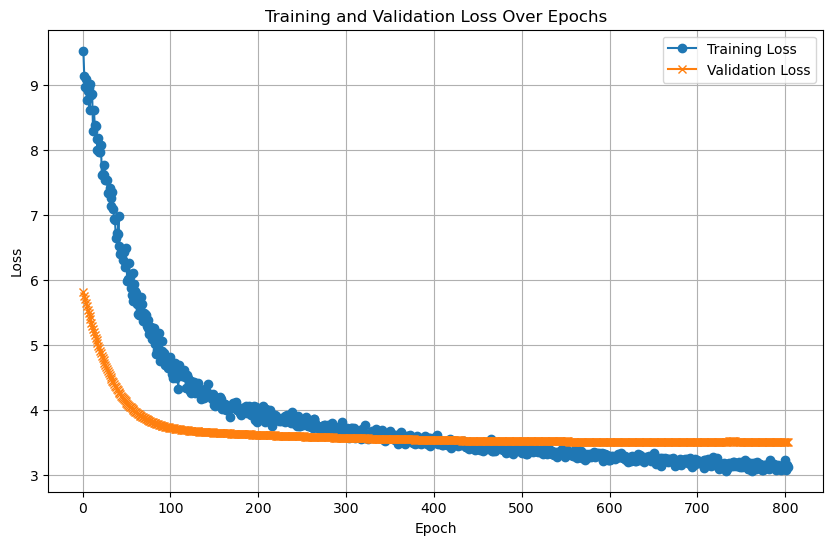

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 5.3529
Test Batch [20/40], Loss: 5.4304
Test Batch [30/40], Loss: 6.0466
Test Batch [40/40], Loss: 5.5302

Test Loss: 5.5887


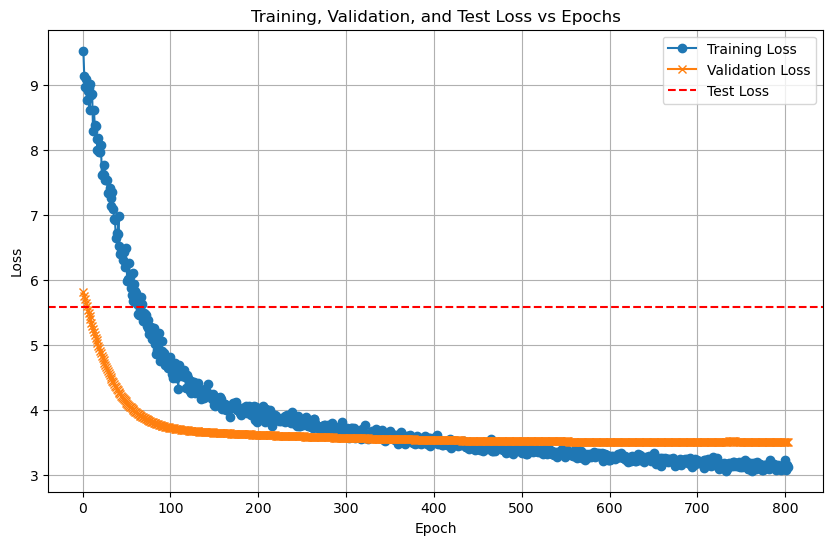

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 42.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.40      0.40      0.40         5
           2       0.00      0.00      0.00         5
           3       0.40      0.40      0.40         5
           4       0.50      0.60      0.55         5
           5       0.00      0.00      0.00         5
           6       0.33      0.40      0.36         5
           7       0.33      0.40      0.36         5
           8       0.50      0.80      0.62         5
           9       0.25      0.40      0.31         5
          10       0.33      0.20      0.25         5
          11       0.00      0.00      0.00         5
          12       0.71      1.00      0.83         5
          13       0.5

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8640  |  Val Loss: 2.8852
Validation loss improved from inf to 2.8852.
[Epoch 2/1000] Train Loss: 2.8470  |  Val Loss: 2.8730
Validation loss improved from 2.8852 to 2.8730.
[Epoch 3/1000] Train Loss: 2.8328  |  Val Loss: 2.8611
Validation loss improved from 2.8730 to 2.8611.
[Epoch 4/1000] Train Loss: 2.8193  |  Val Loss: 2.8502
Validation loss improved from 2.8611 to 2.8502.
[Epoch 5/1000] Train Loss: 2.8051  |  Val Loss: 2.8399
Validation loss improved from 2.8502 to 2.8399.
[Epoch 6/1000] Train Loss: 2.7915  |  Val Loss: 2.8299
Validation loss improved from 2.8399 to 2.8299.
[Epoch 7/1000] Train Loss: 2.7787  |  Val Loss: 2.8202
Validation loss improved from 2.8299 to 2.8202.
[Epoch 8/1000] Train Loss: 2.7671  |  Val Loss: 2.8108
Validation loss improved from 2.8202 to 2.8108.
[Epoch 9/1000] Train Loss: 2.7554  |  Val Loss: 2.8020
Validation loss improved from 2.8108 to 2.8020.
[Epoch 10/1000] Train Loss: 2.7435  |  Val Loss: 2.7934
Validation loss impr

[Epoch 21/1000] Train Loss: 2.6416  |  Val Loss: 2.7158
Validation loss improved from 2.7216 to 2.7158.
[Epoch 22/1000] Train Loss: 2.6337  |  Val Loss: 2.7104
Validation loss improved from 2.7158 to 2.7104.
[Epoch 23/1000] Train Loss: 2.6266  |  Val Loss: 2.7051
Validation loss improved from 2.7104 to 2.7051.
[Epoch 24/1000] Train Loss: 2.6196  |  Val Loss: 2.6998
Validation loss improved from 2.7051 to 2.6998.
[Epoch 25/1000] Train Loss: 2.6122  |  Val Loss: 2.6946
Validation loss improved from 2.6998 to 2.6946.
[Epoch 26/1000] Train Loss: 2.6052  |  Val Loss: 2.6894
Validation loss improved from 2.6946 to 2.6894.
[Epoch 27/1000] Train Loss: 2.5985  |  Val Loss: 2.6842
Validation loss improved from 2.6894 to 2.6842.
[Epoch 28/1000] Train Loss: 2.5916  |  Val Loss: 2.6791
Validation loss improved from 2.6842 to 2.6791.
[Epoch 29/1000] Train Loss: 2.5851  |  Val Loss: 2.6742
Validation loss improved from 2.6791 to 2.6742.
[Epoch 30/1000] Train Loss: 2.5785  |  Val Loss: 2.6695
Validati

[Epoch 38/1000] Train Loss: 2.5263  |  Val Loss: 2.6317
Validation loss improved from 2.6361 to 2.6317.
[Epoch 39/1000] Train Loss: 2.5198  |  Val Loss: 2.6276
Validation loss improved from 2.6317 to 2.6276.
[Epoch 40/1000] Train Loss: 2.5133  |  Val Loss: 2.6233
Validation loss improved from 2.6276 to 2.6233.
[Epoch 41/1000] Train Loss: 2.5073  |  Val Loss: 2.6189
Validation loss improved from 2.6233 to 2.6189.
[Epoch 42/1000] Train Loss: 2.5012  |  Val Loss: 2.6145
Validation loss improved from 2.6189 to 2.6145.
[Epoch 43/1000] Train Loss: 2.4945  |  Val Loss: 2.6100
Validation loss improved from 2.6145 to 2.6100.
[Epoch 44/1000] Train Loss: 2.4884  |  Val Loss: 2.6056
Validation loss improved from 2.6100 to 2.6056.
[Epoch 45/1000] Train Loss: 2.4820  |  Val Loss: 2.6012
Validation loss improved from 2.6056 to 2.6012.
[Epoch 46/1000] Train Loss: 2.4757  |  Val Loss: 2.5968
Validation loss improved from 2.6012 to 2.5968.
[Epoch 47/1000] Train Loss: 2.4695  |  Val Loss: 2.5922
Validati

[Epoch 61/1000] Train Loss: 2.3834  |  Val Loss: 2.5271
Validation loss improved from 2.5326 to 2.5271.
[Epoch 62/1000] Train Loss: 2.3769  |  Val Loss: 2.5220
Validation loss improved from 2.5271 to 2.5220.
[Epoch 63/1000] Train Loss: 2.3707  |  Val Loss: 2.5170
Validation loss improved from 2.5220 to 2.5170.
[Epoch 64/1000] Train Loss: 2.3644  |  Val Loss: 2.5120
Validation loss improved from 2.5170 to 2.5120.
[Epoch 65/1000] Train Loss: 2.3579  |  Val Loss: 2.5070
Validation loss improved from 2.5120 to 2.5070.
[Epoch 66/1000] Train Loss: 2.3516  |  Val Loss: 2.5021
Validation loss improved from 2.5070 to 2.5021.
[Epoch 67/1000] Train Loss: 2.3451  |  Val Loss: 2.4973
Validation loss improved from 2.5021 to 2.4973.
[Epoch 68/1000] Train Loss: 2.3387  |  Val Loss: 2.4924
Validation loss improved from 2.4973 to 2.4924.
[Epoch 69/1000] Train Loss: 2.3323  |  Val Loss: 2.4877
Validation loss improved from 2.4924 to 2.4877.
[Epoch 70/1000] Train Loss: 2.3256  |  Val Loss: 2.4832
Validati

[Epoch 78/1000] Train Loss: 2.2766  |  Val Loss: 2.4443
Validation loss improved from 2.4496 to 2.4443.
[Epoch 79/1000] Train Loss: 2.2706  |  Val Loss: 2.4393
Validation loss improved from 2.4443 to 2.4393.
[Epoch 80/1000] Train Loss: 2.2646  |  Val Loss: 2.4345
Validation loss improved from 2.4393 to 2.4345.
[Epoch 81/1000] Train Loss: 2.2583  |  Val Loss: 2.4298
Validation loss improved from 2.4345 to 2.4298.
[Epoch 82/1000] Train Loss: 2.2523  |  Val Loss: 2.4251
Validation loss improved from 2.4298 to 2.4251.
[Epoch 83/1000] Train Loss: 2.2465  |  Val Loss: 2.4202
Validation loss improved from 2.4251 to 2.4202.
[Epoch 84/1000] Train Loss: 2.2401  |  Val Loss: 2.4152
Validation loss improved from 2.4202 to 2.4152.
[Epoch 85/1000] Train Loss: 2.2340  |  Val Loss: 2.4102
Validation loss improved from 2.4152 to 2.4102.
[Epoch 86/1000] Train Loss: 2.2282  |  Val Loss: 2.4052
Validation loss improved from 2.4102 to 2.4052.
[Epoch 87/1000] Train Loss: 2.2217  |  Val Loss: 2.4006
Validati

[Epoch 103/1000] Train Loss: 2.1239  |  Val Loss: 2.3294
Validation loss improved from 2.3334 to 2.3294.
[Epoch 104/1000] Train Loss: 2.1185  |  Val Loss: 2.3257
Validation loss improved from 2.3294 to 2.3257.
[Epoch 105/1000] Train Loss: 2.1126  |  Val Loss: 2.3217
Validation loss improved from 2.3257 to 2.3217.
[Epoch 106/1000] Train Loss: 2.1073  |  Val Loss: 2.3176
Validation loss improved from 2.3217 to 2.3176.
[Epoch 107/1000] Train Loss: 2.1017  |  Val Loss: 2.3133
Validation loss improved from 2.3176 to 2.3133.
[Epoch 108/1000] Train Loss: 2.0956  |  Val Loss: 2.3094
Validation loss improved from 2.3133 to 2.3094.
[Epoch 109/1000] Train Loss: 2.0896  |  Val Loss: 2.3059
Validation loss improved from 2.3094 to 2.3059.
[Epoch 110/1000] Train Loss: 2.0838  |  Val Loss: 2.3026
Validation loss improved from 2.3059 to 2.3026.
[Epoch 111/1000] Train Loss: 2.0781  |  Val Loss: 2.2994
Validation loss improved from 2.3026 to 2.2994.
[Epoch 112/1000] Train Loss: 2.0726  |  Val Loss: 2.296

[Epoch 120/1000] Train Loss: 2.0286  |  Val Loss: 2.2659
Validation loss improved from 2.2698 to 2.2659.
[Epoch 121/1000] Train Loss: 2.0231  |  Val Loss: 2.2623
Validation loss improved from 2.2659 to 2.2623.
[Epoch 122/1000] Train Loss: 2.0177  |  Val Loss: 2.2587
Validation loss improved from 2.2623 to 2.2587.
[Epoch 123/1000] Train Loss: 2.0120  |  Val Loss: 2.2548
Validation loss improved from 2.2587 to 2.2548.
[Epoch 124/1000] Train Loss: 2.0065  |  Val Loss: 2.2509
Validation loss improved from 2.2548 to 2.2509.
[Epoch 125/1000] Train Loss: 2.0013  |  Val Loss: 2.2472
Validation loss improved from 2.2509 to 2.2472.
[Epoch 126/1000] Train Loss: 1.9956  |  Val Loss: 2.2433
Validation loss improved from 2.2472 to 2.2433.
[Epoch 127/1000] Train Loss: 1.9906  |  Val Loss: 2.2395
Validation loss improved from 2.2433 to 2.2395.
[Epoch 128/1000] Train Loss: 1.9852  |  Val Loss: 2.2358
Validation loss improved from 2.2395 to 2.2358.
[Epoch 129/1000] Train Loss: 1.9800  |  Val Loss: 2.231

[Epoch 140/1000] Train Loss: 1.9193  |  Val Loss: 2.1853
Validation loss improved from 2.1893 to 2.1853.
[Epoch 141/1000] Train Loss: 1.9137  |  Val Loss: 2.1815
Validation loss improved from 2.1853 to 2.1815.
[Epoch 142/1000] Train Loss: 1.9082  |  Val Loss: 2.1771
Validation loss improved from 2.1815 to 2.1771.
[Epoch 143/1000] Train Loss: 1.9027  |  Val Loss: 2.1726
Validation loss improved from 2.1771 to 2.1726.
[Epoch 144/1000] Train Loss: 1.8972  |  Val Loss: 2.1685
Validation loss improved from 2.1726 to 2.1685.
[Epoch 145/1000] Train Loss: 1.8916  |  Val Loss: 2.1642
Validation loss improved from 2.1685 to 2.1642.
[Epoch 146/1000] Train Loss: 1.8861  |  Val Loss: 2.1600
Validation loss improved from 2.1642 to 2.1600.
[Epoch 147/1000] Train Loss: 1.8808  |  Val Loss: 2.1556
Validation loss improved from 2.1600 to 2.1556.
[Epoch 148/1000] Train Loss: 1.8756  |  Val Loss: 2.1516
Validation loss improved from 2.1556 to 2.1516.
[Epoch 149/1000] Train Loss: 1.8700  |  Val Loss: 2.148

[Epoch 157/1000] Train Loss: 1.8291  |  Val Loss: 2.1215
Validation loss improved from 2.1240 to 2.1215.
[Epoch 158/1000] Train Loss: 1.8242  |  Val Loss: 2.1190
Validation loss improved from 2.1215 to 2.1190.
[Epoch 159/1000] Train Loss: 1.8191  |  Val Loss: 2.1165
Validation loss improved from 2.1190 to 2.1165.
[Epoch 160/1000] Train Loss: 1.8139  |  Val Loss: 2.1139
Validation loss improved from 2.1165 to 2.1139.
[Epoch 161/1000] Train Loss: 1.8090  |  Val Loss: 2.1115
Validation loss improved from 2.1139 to 2.1115.
[Epoch 162/1000] Train Loss: 1.8036  |  Val Loss: 2.1090
Validation loss improved from 2.1115 to 2.1090.
[Epoch 163/1000] Train Loss: 1.7988  |  Val Loss: 2.1062
Validation loss improved from 2.1090 to 2.1062.
[Epoch 164/1000] Train Loss: 1.7938  |  Val Loss: 2.1028
Validation loss improved from 2.1062 to 2.1028.
[Epoch 165/1000] Train Loss: 1.7889  |  Val Loss: 2.0996
Validation loss improved from 2.1028 to 2.0996.
[Epoch 166/1000] Train Loss: 1.7839  |  Val Loss: 2.096

[Epoch 182/1000] Train Loss: 1.7080  |  Val Loss: 2.0526
Validation loss improved from 2.0571 to 2.0526.
[Epoch 183/1000] Train Loss: 1.7031  |  Val Loss: 2.0484
Validation loss improved from 2.0526 to 2.0484.
[Epoch 184/1000] Train Loss: 1.6982  |  Val Loss: 2.0447
Validation loss improved from 2.0484 to 2.0447.
[Epoch 185/1000] Train Loss: 1.6932  |  Val Loss: 2.0420
Validation loss improved from 2.0447 to 2.0420.
[Epoch 186/1000] Train Loss: 1.6885  |  Val Loss: 2.0399
Validation loss improved from 2.0420 to 2.0399.
[Epoch 187/1000] Train Loss: 1.6838  |  Val Loss: 2.0377
Validation loss improved from 2.0399 to 2.0377.
[Epoch 188/1000] Train Loss: 1.6793  |  Val Loss: 2.0355
Validation loss improved from 2.0377 to 2.0355.
[Epoch 189/1000] Train Loss: 1.6750  |  Val Loss: 2.0327
Validation loss improved from 2.0355 to 2.0327.
[Epoch 190/1000] Train Loss: 1.6702  |  Val Loss: 2.0295
Validation loss improved from 2.0327 to 2.0295.
[Epoch 191/1000] Train Loss: 1.6656  |  Val Loss: 2.025

[Epoch 202/1000] Train Loss: 1.6168  |  Val Loss: 2.0054
Validation loss improved from 2.0071 to 2.0054.
[Epoch 203/1000] Train Loss: 1.6119  |  Val Loss: 2.0037
Validation loss improved from 2.0054 to 2.0037.
[Epoch 204/1000] Train Loss: 1.6072  |  Val Loss: 2.0019
Validation loss improved from 2.0037 to 2.0019.
[Epoch 205/1000] Train Loss: 1.6024  |  Val Loss: 1.9997
Validation loss improved from 2.0019 to 1.9997.
[Epoch 206/1000] Train Loss: 1.5979  |  Val Loss: 1.9975
Validation loss improved from 1.9997 to 1.9975.
[Epoch 207/1000] Train Loss: 1.5931  |  Val Loss: 1.9954
Validation loss improved from 1.9975 to 1.9954.
[Epoch 208/1000] Train Loss: 1.5889  |  Val Loss: 1.9926
Validation loss improved from 1.9954 to 1.9926.
[Epoch 209/1000] Train Loss: 1.5841  |  Val Loss: 1.9901
Validation loss improved from 1.9926 to 1.9901.
[Epoch 210/1000] Train Loss: 1.5793  |  Val Loss: 1.9877
Validation loss improved from 1.9901 to 1.9877.
[Epoch 211/1000] Train Loss: 1.5749  |  Val Loss: 1.985

[Epoch 225/1000] Train Loss: 1.5161  |  Val Loss: 1.9535
Validation loss improved from 1.9554 to 1.9535.
[Epoch 226/1000] Train Loss: 1.5116  |  Val Loss: 1.9518
Validation loss improved from 1.9535 to 1.9518.
[Epoch 227/1000] Train Loss: 1.5078  |  Val Loss: 1.9501
Validation loss improved from 1.9518 to 1.9501.
[Epoch 228/1000] Train Loss: 1.5028  |  Val Loss: 1.9484
Validation loss improved from 1.9501 to 1.9484.
[Epoch 229/1000] Train Loss: 1.4985  |  Val Loss: 1.9469
Validation loss improved from 1.9484 to 1.9469.
[Epoch 230/1000] Train Loss: 1.4941  |  Val Loss: 1.9461
Validation loss improved from 1.9469 to 1.9461.
[Epoch 231/1000] Train Loss: 1.4899  |  Val Loss: 1.9451
Validation loss improved from 1.9461 to 1.9451.
[Epoch 232/1000] Train Loss: 1.4857  |  Val Loss: 1.9439
Validation loss improved from 1.9451 to 1.9439.
[Epoch 233/1000] Train Loss: 1.4816  |  Val Loss: 1.9428
Validation loss improved from 1.9439 to 1.9428.
[Epoch 234/1000] Train Loss: 1.4778  |  Val Loss: 1.941

[Epoch 242/1000] Train Loss: 1.4456  |  Val Loss: 1.9288
Validation loss improved from 1.9308 to 1.9288.
[Epoch 243/1000] Train Loss: 1.4414  |  Val Loss: 1.9264
Validation loss improved from 1.9288 to 1.9264.
[Epoch 244/1000] Train Loss: 1.4375  |  Val Loss: 1.9238
Validation loss improved from 1.9264 to 1.9238.
[Epoch 245/1000] Train Loss: 1.4338  |  Val Loss: 1.9206
Validation loss improved from 1.9238 to 1.9206.
[Epoch 246/1000] Train Loss: 1.4298  |  Val Loss: 1.9178
Validation loss improved from 1.9206 to 1.9178.
[Epoch 247/1000] Train Loss: 1.4260  |  Val Loss: 1.9151
Validation loss improved from 1.9178 to 1.9151.
[Epoch 248/1000] Train Loss: 1.4219  |  Val Loss: 1.9125
Validation loss improved from 1.9151 to 1.9125.
[Epoch 249/1000] Train Loss: 1.4181  |  Val Loss: 1.9103
Validation loss improved from 1.9125 to 1.9103.
[Epoch 250/1000] Train Loss: 1.4137  |  Val Loss: 1.9087
Validation loss improved from 1.9103 to 1.9087.
[Epoch 251/1000] Train Loss: 1.4097  |  Val Loss: 1.907

[Epoch 265/1000] Train Loss: 1.3557  |  Val Loss: 1.8888
Validation loss improved from 1.8894 to 1.8888.
[Epoch 266/1000] Train Loss: 1.3518  |  Val Loss: 1.8877
Validation loss improved from 1.8888 to 1.8877.
[Epoch 267/1000] Train Loss: 1.3477  |  Val Loss: 1.8863
Validation loss improved from 1.8877 to 1.8863.
[Epoch 268/1000] Train Loss: 1.3439  |  Val Loss: 1.8846
Validation loss improved from 1.8863 to 1.8846.
[Epoch 269/1000] Train Loss: 1.3399  |  Val Loss: 1.8830
Validation loss improved from 1.8846 to 1.8830.
[Epoch 270/1000] Train Loss: 1.3360  |  Val Loss: 1.8813
Validation loss improved from 1.8830 to 1.8813.
[Epoch 271/1000] Train Loss: 1.3322  |  Val Loss: 1.8791
Validation loss improved from 1.8813 to 1.8791.
[Epoch 272/1000] Train Loss: 1.3285  |  Val Loss: 1.8773
Validation loss improved from 1.8791 to 1.8773.
[Epoch 273/1000] Train Loss: 1.3250  |  Val Loss: 1.8766
Validation loss improved from 1.8773 to 1.8766.
[Epoch 274/1000] Train Loss: 1.3213  |  Val Loss: 1.876

[Epoch 284/1000] Train Loss: 1.2843  |  Val Loss: 1.8681
Validation loss improved from 1.8711 to 1.8681.
[Epoch 285/1000] Train Loss: 1.2809  |  Val Loss: 1.8648
Validation loss improved from 1.8681 to 1.8648.
[Epoch 286/1000] Train Loss: 1.2776  |  Val Loss: 1.8620
Validation loss improved from 1.8648 to 1.8620.
[Epoch 287/1000] Train Loss: 1.2741  |  Val Loss: 1.8597
Validation loss improved from 1.8620 to 1.8597.
[Epoch 288/1000] Train Loss: 1.2708  |  Val Loss: 1.8571
Validation loss improved from 1.8597 to 1.8571.
[Epoch 289/1000] Train Loss: 1.2681  |  Val Loss: 1.8541
Validation loss improved from 1.8571 to 1.8541.
[Epoch 290/1000] Train Loss: 1.2648  |  Val Loss: 1.8514
Validation loss improved from 1.8541 to 1.8514.
[Epoch 291/1000] Train Loss: 1.2618  |  Val Loss: 1.8495
Validation loss improved from 1.8514 to 1.8495.
[Epoch 292/1000] Train Loss: 1.2586  |  Val Loss: 1.8483
Validation loss improved from 1.8495 to 1.8483.
[Epoch 293/1000] Train Loss: 1.2554  |  Val Loss: 1.847

[Epoch 307/1000] Train Loss: 1.2050  |  Val Loss: 1.8592
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 308/1000] Train Loss: 1.2018  |  Val Loss: 1.8587
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 309/1000] Train Loss: 1.1986  |  Val Loss: 1.8577
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 310/1000] Train Loss: 1.1949  |  Val Loss: 1.8566
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 311/1000] Train Loss: 1.1915  |  Val Loss: 1.8554
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 312/1000] Train Loss: 1.1883  |  Val Loss: 1.8534
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 313/1000] Train Loss: 1.1848  |  Val Loss: 1.8509
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 314/1000] Train Loss: 1.1815  |  Val Loss: 1.8485
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 315/1000] Train Loss: 1.1780  |  Val Loss: 1.8453
!! Validation loss did NOT improve !! Patience:

[Epoch 324/1000] Train Loss: 1.1510  |  Val Loss: 1.8235
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 325/1000] Train Loss: 1.1479  |  Val Loss: 1.8237
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 326/1000] Train Loss: 1.1452  |  Val Loss: 1.8238
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 327/1000] Train Loss: 1.1421  |  Val Loss: 1.8241
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 328/1000] Train Loss: 1.1393  |  Val Loss: 1.8239
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 329/1000] Train Loss: 1.1362  |  Val Loss: 1.8238
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 330/1000] Train Loss: 1.1328  |  Val Loss: 1.8235
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 331/1000] Train Loss: 1.1294  |  Val Loss: 1.8230
Validation loss improved from 1.8231 to 1.8230.
[Epoch 332/1000] Train Loss: 1.1267  |  Val Loss: 1.8229
Validation loss improved from 1.8230 to 1.8229.
[Epoch 333/10

[Epoch 348/1000] Train Loss: 1.0854  |  Val Loss: 1.8344
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 349/1000] Train Loss: 1.0823  |  Val Loss: 1.8333
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 350/1000] Train Loss: 1.0794  |  Val Loss: 1.8331
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 351/1000] Train Loss: 1.0764  |  Val Loss: 1.8339
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 352/1000] Train Loss: 1.0733  |  Val Loss: 1.8347
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 353/1000] Train Loss: 1.0713  |  Val Loss: 1.8346
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 354/1000] Train Loss: 1.0686  |  Val Loss: 1.8333
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 355/1000] Train Loss: 1.0659  |  Val Loss: 1.8314
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 356/1000] Train Loss: 1.0636  |  Val Loss: 1.8299
!! Validation loss did NOT improve !! Patience:

[Epoch 364/1000] Train Loss: 1.0438  |  Val Loss: 1.8306
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 365/1000] Train Loss: 1.0417  |  Val Loss: 1.8305
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 366/1000] Train Loss: 1.0394  |  Val Loss: 1.8302
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 367/1000] Train Loss: 1.0373  |  Val Loss: 1.8295
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 368/1000] Train Loss: 1.0350  |  Val Loss: 1.8284
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 369/1000] Train Loss: 1.0322  |  Val Loss: 1.8269
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 370/1000] Train Loss: 1.0295  |  Val Loss: 1.8248
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 371/1000] Train Loss: 1.0277  |  Val Loss: 1.8223
Validation loss improved from 1.8229 to 1.8223.
[Epoch 372/1000] Train Loss: 1.0251  |  Val Loss: 1.8201
Validation loss improved from 1.8223 to 1.8201.
[Epoch

[Epoch 390/1000] Train Loss: 0.9891  |  Val Loss: 1.8206
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 391/1000] Train Loss: 0.9859  |  Val Loss: 1.8184
Validation loss improved from 1.8185 to 1.8184.
[Epoch 392/1000] Train Loss: 0.9837  |  Val Loss: 1.8158
Validation loss improved from 1.8184 to 1.8158.
[Epoch 393/1000] Train Loss: 0.9805  |  Val Loss: 1.8136
Validation loss improved from 1.8158 to 1.8136.
[Epoch 394/1000] Train Loss: 0.9785  |  Val Loss: 1.8114
Validation loss improved from 1.8136 to 1.8114.
[Epoch 395/1000] Train Loss: 0.9759  |  Val Loss: 1.8098
Validation loss improved from 1.8114 to 1.8098.
[Epoch 396/1000] Train Loss: 0.9741  |  Val Loss: 1.8094
Validation loss improved from 1.8098 to 1.8094.
[Epoch 397/1000] Train Loss: 0.9717  |  Val Loss: 1.8098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 398/1000] Train Loss: 0.9704  |  Val Loss: 1.8110
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 399/1000] Train Loss: 0.9684 

[Epoch 411/1000] Train Loss: 0.9441  |  Val Loss: 1.8225
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 412/1000] Train Loss: 0.9423  |  Val Loss: 1.8236
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 413/1000] Train Loss: 0.9406  |  Val Loss: 1.8244
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 414/1000] Train Loss: 0.9389  |  Val Loss: 1.8249
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 415/1000] Train Loss: 0.9374  |  Val Loss: 1.8253
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 416/1000] Train Loss: 0.9358  |  Val Loss: 1.8266
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 417/1000] Train Loss: 0.9346  |  Val Loss: 1.8272
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 418/1000] Train Loss: 0.9331  |  Val Loss: 1.8263
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 419/1000] Train Loss: 0.9311  |  Val Loss: 1.8253
!! Validation loss did NOT improve !! Patience:

[Epoch 432/1000] Train Loss: 0.9085  |  Val Loss: 1.8283
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 433/1000] Train Loss: 0.9080  |  Val Loss: 1.8286
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 434/1000] Train Loss: 0.9070  |  Val Loss: 1.8290
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 435/1000] Train Loss: 0.9048  |  Val Loss: 1.8306
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 436/1000] Train Loss: 0.9030  |  Val Loss: 1.8326
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 437/1000] Train Loss: 0.9009  |  Val Loss: 1.8346
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 438/1000] Train Loss: 0.8990  |  Val Loss: 1.8375
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 439/1000] Train Loss: 0.8965  |  Val Loss: 1.8403
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 440/1000] Train Loss: 0.8951  |  Val Loss: 1.8422
!! Validation loss did NOT improve !! Patience:

[Epoch 454/1000] Train Loss: 0.8755  |  Val Loss: 1.8460
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 455/1000] Train Loss: 0.8747  |  Val Loss: 1.8468
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 456/1000] Train Loss: 0.8737  |  Val Loss: 1.8465
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 457/1000] Train Loss: 0.8717  |  Val Loss: 1.8456
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 458/1000] Train Loss: 0.8693  |  Val Loss: 1.8450
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 459/1000] Train Loss: 0.8670  |  Val Loss: 1.8438
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 460/1000] Train Loss: 0.8653  |  Val Loss: 1.8420
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 461/1000] Train Loss: 0.8628  |  Val Loss: 1.8402
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 462/1000] Train Loss: 0.8612  |  Val Loss: 1.8390
!! Validation loss did NOT improve !! Patience:

[Epoch 474/1000] Train Loss: 0.8455  |  Val Loss: 1.8576
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 475/1000] Train Loss: 0.8441  |  Val Loss: 1.8579
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 476/1000] Train Loss: 0.8432  |  Val Loss: 1.8568
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 477/1000] Train Loss: 0.8418  |  Val Loss: 1.8560
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 478/1000] Train Loss: 0.8400  |  Val Loss: 1.8565
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 479/1000] Train Loss: 0.8395  |  Val Loss: 1.8566
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 480/1000] Train Loss: 0.8380  |  Val Loss: 1.8563
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 481/1000] Train Loss: 0.8369  |  Val Loss: 1.8559
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 482/1000] Train Loss: 0.8361  |  Val Loss: 1.8557
!! Validation loss did NOT improve !! Patience:

[Epoch 496/1000] Train Loss: 0.8187  |  Val Loss: 1.8637
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 496 !!
No improvement for 100 epochs.


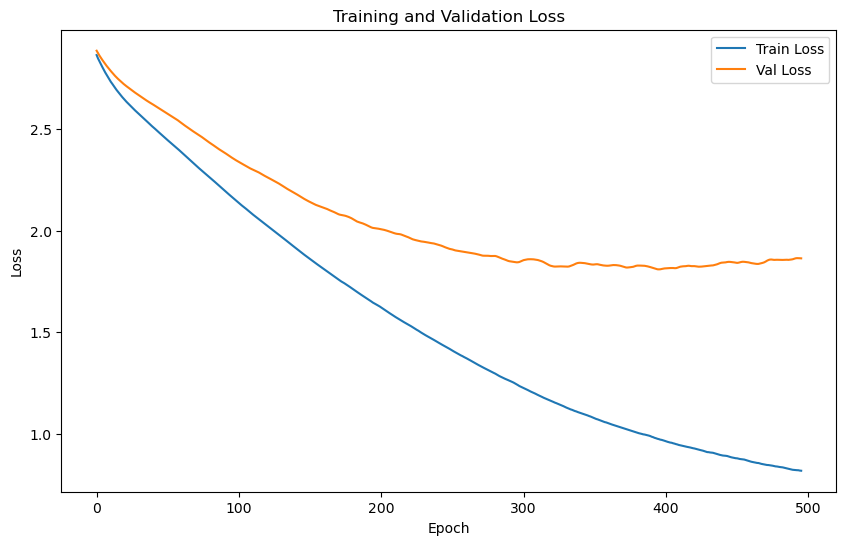

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9575 | Test Accuracy: 31.01%


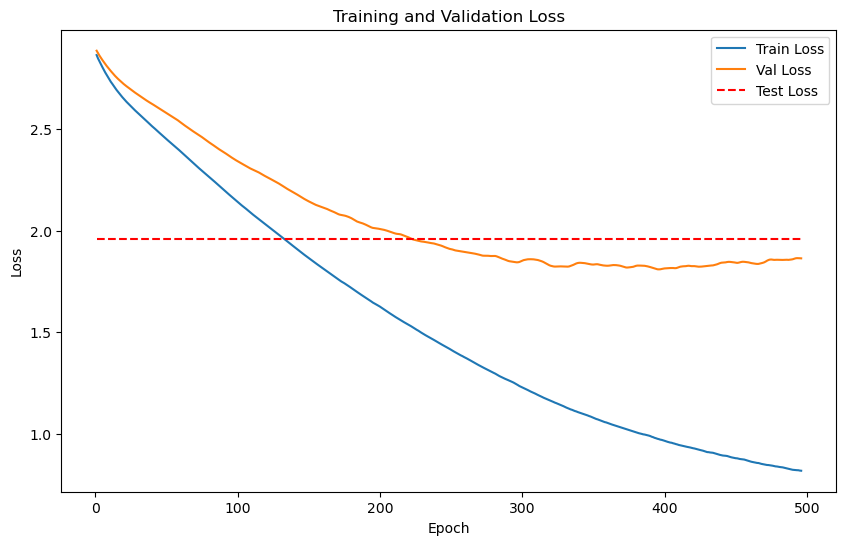

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5301
    Batch [2/2], Val Loss: 0.3435
Epoch [1/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.4368

Validation loss improved from inf to 0.4368. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.3439
Epoch [2/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.4364

Validation loss improved from 0.4368 to 0.4364. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.3446
Epoch [3/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.4362

Validation loss improved from 0.4364 to 0.4362. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5263
    Batch [2/2], Val Loss: 0.3451
Epoch [4/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4357

Validation loss improved from 0.4362 to 0.4357. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.3448
Epoch [5/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4349

Validation loss improved from 0.4357 to 0.4349. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5233
    Batch [2/2], Val Loss: 0.3444
Epoch [6/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.4339

Validation loss improved from 0.4349 to 0.4339. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.3439
Epoch [7/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.4328

Validation loss improved from 0.4339 to 0.4328. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.3434
Epoch [8/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4319

Validation loss improved from 0.4328 to 0.4319. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.3429
Epoch [9/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4310

Validation loss improved from 0.4319 to 0.4310. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.3421
Epoch [10/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4299

Validation loss improved from 0.4310 to 0.4299. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.3412
Epoch [11/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4288

Validation loss improved from 0.4299 to 0.4288. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.3405
Epoch [12/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4279

Validation loss improved from 0.4288 to 0.4279. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.3398
Epoch [13/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4272

Validation loss improved from 0.4279 to 0.4272. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.3394
Epoch [14/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4265

Validation loss improved from 0.4272 to 0.4265. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.3392
Epoch [15/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4259

Validation loss improved from 0.4265 to 0.4259. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.3392
Epoch [16/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4253

Validation loss improved from 0.4259 to 0.4253. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.3389
Epoch [17/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4247

Validation loss improved from 0.4253 to 0.4247. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.3387
Epoch [18/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4241

Validation loss improved from 0.4247 to 0.4241. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.3387
Epoch [19/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4236

Validation loss improved from 0.4241 to 0.4236. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.3387
Epoch [20/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4230

Validation loss improved from 0.4236 to 0.4230. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.3386
Epoch [21/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4226

Validation loss improved from 0.4230 to 0.4226. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.3385
Epoch [22/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4222

Validation loss improved from 0.4226 to 0.4222. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.3386
Epoch [23/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4219

Validation loss improved from 0.4222 to 0.4219. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.3387
Epoch [24/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4217

Validation loss improved from 0.4219 to 0.4217. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.3388
Epoch [25/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4217

Validation loss improved from 0.4217 to 0.4217. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.3388
Epoch [26/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4216

Validation loss improved from 0.4217 to 0.4216. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.3389
Epoch [27/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4215

Validation loss improved from 0.4216 to 0.4215. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.3389
Epoch [28/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4214

Validation loss improved from 0.4215 to 0.4214. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.3390
Epoch [29/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4214

Validation loss improved from 0.4214 to 0.4214. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.3390
Epoch [30/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4213

Validation loss improved from 0.4214 to 0.4213. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.3390
Epoch [31/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4213

Validation loss improved from 0.4213 to 0.4213. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.3390
Epoch [32/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4212

Validation loss improved from 0.4213 to 0.4212. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.3390
Epoch [33/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4211

Validation loss improved from 0.4212 to 0.4211. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.3391
Epoch [34/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4210

Validation loss improved from 0.4211 to 0.4210. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.3390
Epoch [35/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4209

Validation loss improved from 0.4210 to 0.4209. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.3390
Epoch [36/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4208

Validation loss improved from 0.4209 to 0.4208. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.3390
Epoch [37/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4207

Validation loss improved from 0.4208 to 0.4207. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3389
Epoch [38/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4206

Validation loss improved from 0.4207 to 0.4206. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.3389
Epoch [39/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4205

Validation loss improved from 0.4206 to 0.4205. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.3389
Epoch [40/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.4204

Validation loss improved from 0.4205 to 0.4204. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.3390
Epoch [41/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4204

Validation loss improved from 0.4204 to 0.4204. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.3391
Epoch [42/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4204

Validation loss improved from 0.4204 to 0.4204. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.3391
Epoch [43/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4203

Validation loss improved from 0.4204 to 0.4203. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3391
Epoch [44/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4202

Validation loss improved from 0.4203 to 0.4202. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3392
Epoch [45/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4202

Validation loss improved from 0.4202 to 0.4202. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3392
Epoch [46/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4201

Validation loss improved from 0.4202 to 0.4201. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3391
Epoch [47/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4200

Validation loss improved from 0.4201 to 0.4200. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3391
Epoch [48/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4199

Validation loss improved from 0.4200 to 0.4199. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3391
Epoch [49/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4198

Validation loss improved from 0.4199 to 0.4198. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.3390
Epoch [50/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4197

Validation loss improved from 0.4198 to 0.4197. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.3390
Epoch [51/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4196

Validation loss improved from 0.4197 to 0.4196. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.3390
Epoch [52/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4195

Validation loss improved from 0.4196 to 0.4195. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.3389
Epoch [53/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4194

Validation loss improved from 0.4195 to 0.4194. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.3389
Epoch [54/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4193

Validation loss improved from 0.4194 to 0.4193. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.3388
Epoch [55/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4192

Validation loss improved from 0.4193 to 0.4192. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.3388
Epoch [56/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4192

Validation loss improved from 0.4192 to 0.4192. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.3388
Epoch [57/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4191

Validation loss improved from 0.4192 to 0.4191. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.3388
Epoch [58/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4190

Validation loss improved from 0.4191 to 0.4190. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.3387
Epoch [59/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4189

Validation loss improved from 0.4190 to 0.4189. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.3387
Epoch [60/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4188

Validation loss improved from 0.4189 to 0.4188. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.3386
Epoch [61/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4187

Validation loss improved from 0.4188 to 0.4187. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.3386
Epoch [62/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4186

Validation loss improved from 0.4187 to 0.4186. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.3386
Epoch [63/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4185

Validation loss improved from 0.4186 to 0.4185. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.3386
Epoch [64/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4185

Validation loss improved from 0.4185 to 0.4185. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.3387
Epoch [65/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4184

Validation loss improved from 0.4185 to 0.4184. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.3387
Epoch [66/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4184

Validation loss improved from 0.4184 to 0.4184. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.3388
Epoch [67/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4184

Validation loss improved from 0.4184 to 0.4184. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.3388
Epoch [68/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4183

Validation loss improved from 0.4184 to 0.4183. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.3388
Epoch [69/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4183

Validation loss improved from 0.4183 to 0.4183. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.3388
Epoch [70/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4182

Validation loss improved from 0.4183 to 0.4182. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.3388
Epoch [71/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4181

Validation loss improved from 0.4182 to 0.4181. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.3387
Epoch [72/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4180

Validation loss improved from 0.4181 to 0.4180. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.3386
Epoch [73/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4179

Validation loss improved from 0.4180 to 0.4179. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.3385
Epoch [74/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4179

Validation loss improved from 0.4179 to 0.4179. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.3384
Epoch [75/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4177

Validation loss improved from 0.4179 to 0.4177. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.3383
Epoch [76/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4176

Validation loss improved from 0.4177 to 0.4176. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.3382
Epoch [77/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4175

Validation loss improved from 0.4176 to 0.4175. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.3382
Epoch [78/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4174

Validation loss improved from 0.4175 to 0.4174. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.3382
Epoch [79/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4174

Validation loss improved from 0.4174 to 0.4174. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.3382
Epoch [80/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4173

Validation loss improved from 0.4174 to 0.4173. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.3381
Epoch [81/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4172

Validation loss improved from 0.4173 to 0.4172. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.3381
Epoch [82/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4171

Validation loss improved from 0.4172 to 0.4171. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.3381
Epoch [83/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4171

Validation loss improved from 0.4171 to 0.4171. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.3381
Epoch [84/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4170

Validation loss improved from 0.4171 to 0.4170. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.3381
Epoch [85/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4169

Validation loss improved from 0.4170 to 0.4169. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.3381
Epoch [86/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4169

Validation loss improved from 0.4169 to 0.4169. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.3381
Epoch [87/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4168

Validation loss improved from 0.4169 to 0.4168. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.3382
Epoch [88/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4168

Validation loss improved from 0.4168 to 0.4168. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.3382
Epoch [89/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4168

Validation loss improved from 0.4168 to 0.4168. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.3383
Epoch [90/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4167

Validation loss improved from 0.4168 to 0.4167. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.3382
Epoch [91/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4167

Validation loss improved from 0.4167 to 0.4167. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.3382
Epoch [92/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4166

Validation loss improved from 0.4167 to 0.4166. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.3383
Epoch [93/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4166

Validation loss improved from 0.4166 to 0.4166. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.3383
Epoch [94/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4165

Validation loss improved from 0.4166 to 0.4165. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.3383
Epoch [95/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4165

Validation loss improved from 0.4165 to 0.4165. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.3383
Epoch [96/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4165

Validation loss improved from 0.4165 to 0.4165. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.3383
Epoch [97/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4164

Validation loss improved from 0.4165 to 0.4164. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4529
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.3382
Epoch [98/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4163

Validation loss improved from 0.4164 to 0.4163. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.3382
Epoch [99/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4163

Validation loss improved from 0.4163 to 0.4163. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.3382
Epoch [100/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4163

Validation loss improved from 0.4163 to 0.4163. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.3382
Epoch [101/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4162

Validation loss improved from 0.4163 to 0.4162. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.3382
Epoch [102/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4162

Validation loss improved from 0.4162 to 0.4162. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.3382
Epoch [103/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4162

Validation loss improved from 0.4162 to 0.4162. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3382
Epoch [104/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4161

Validation loss improved from 0.4162 to 0.4161. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3382
Epoch [105/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4161

Validation loss improved from 0.4161 to 0.4161. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.3382
Epoch [106/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4161

Validation loss improved from 0.4161 to 0.4161. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.3382
Epoch [107/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4161

Validation loss improved from 0.4161 to 0.4161. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.3382
Epoch [108/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4161

Validation loss improved from 0.4161 to 0.4161. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.3383
Epoch [109/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4161

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.3384
Epoch [110/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4161

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.3386
Epoch [111/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4162

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.3387
Epoch [112/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4162

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.3389
Epoch [113/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4163

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.3391
Epoch [114/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4164

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.3393
Epoch [115/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4165

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.3395
Epoch [116/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4165

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.3397
Epoch [117/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.3398
Epoch [118/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.3399
Epoch [119/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.3401
Epoch [120/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.3402
Epoch [121/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.3404
Epoch [122/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.3405
Epoch [123/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.3405
Epoch [124/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3406
Epoch [125/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3406
Epoch [126/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.3407
Epoch [127/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.3407
Epoch [128/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.3407
Epoch [129/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.3407
Epoch [130/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.3407
Epoch [131/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.3407
Epoch [132/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3407
Epoch [133/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3408
Epoch [134/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3409
Epoch [135/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3409
Epoch [136/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3410
Epoch [137/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3410
Epoch [138/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4167

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3411
Epoch [139/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3411
Epoch [140/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3412
Epoch [141/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3412
Epoch [142/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3413
Epoch [143/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3413
Epoch [144/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3413
Epoch [145/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3414
Epoch [146/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3414
Epoch [147/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3414
Epoch [148/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3415
Epoch [149/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3415
Epoch [150/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3415
Epoch [151/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3416
Epoch [152/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3416
Epoch [153/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3416
Epoch [154/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [155/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [156/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [157/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [158/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [159/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3417
Epoch [160/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3417
Epoch [161/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3417
Epoch [162/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3417
Epoch [163/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [164/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [165/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [166/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [167/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [168/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [169/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [170/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [171/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [172/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [173/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [174/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [175/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [176/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [177/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [178/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [179/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [180/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [181/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [182/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [183/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [184/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [185/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [186/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [187/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [188/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [189/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [190/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [191/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [192/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [193/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [194/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [195/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [196/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [197/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [198/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [199/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [200/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [201/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [202/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [203/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [204/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [205/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [206/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [207/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3418
Epoch [208/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 208!!
No improvement for 100 epochs


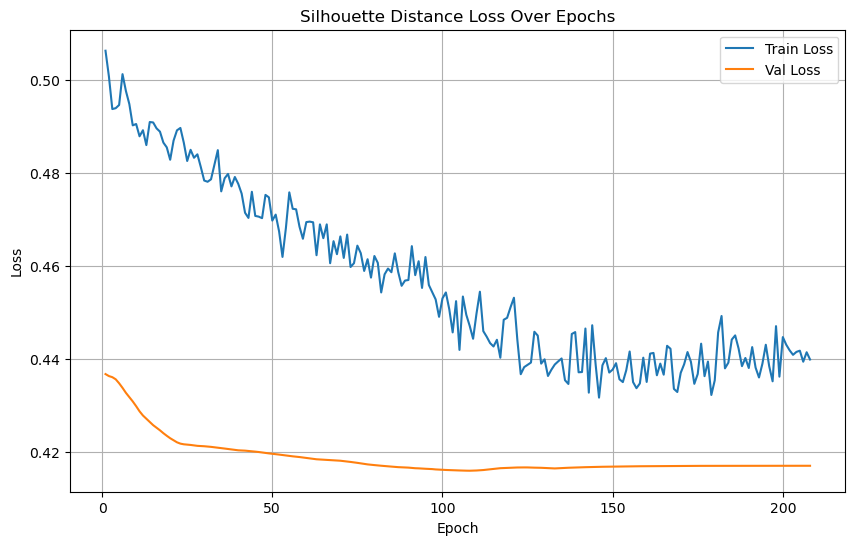

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/158], Loss: 0.4339


Test Batch [20/158], Loss: 0.3528
Test Batch [30/158], Loss: 0.4340


Test Batch [40/158], Loss: 0.2849


Test Batch [50/158], Loss: 0.4385
Test Batch [60/158], Loss: 0.4092


Test Batch [70/158], Loss: 0.2416
Test Batch [80/158], Loss: 0.2009
Test Batch [90/158], Loss: 0.2714
Test Batch [100/158], Loss: 0.2765
Test Batch [110/158], Loss: 0.2853
Test Batch [120/158], Loss: 0.2446


Test Batch [130/158], Loss: 0.5000
Test Batch [140/158], Loss: 0.4073
Test Batch [150/158], Loss: 0.3336



Test Loss: 0.3316


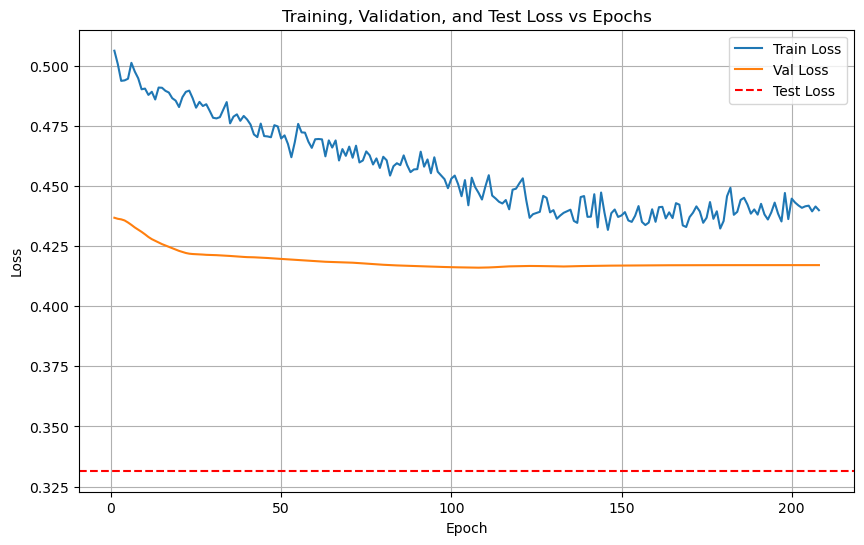

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/158 for test dataset.


  Processed batch 20/158 for test dataset.


  Processed batch 30/158 for test dataset.
  Processed batch 40/158 for test dataset.


  Processed batch 50/158 for test dataset.


  Processed batch 60/158 for test dataset.
  Processed batch 70/158 for test dataset.
  Processed batch 80/158 for test dataset.


  Processed batch 90/158 for test dataset.


  Processed batch 100/158 for test dataset.
  Processed batch 110/158 for test dataset.


  Processed batch 120/158 for test dataset.


  Processed batch 130/158 for test dataset.


  Processed batch 140/158 for test dataset.


  Processed batch 150/158 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.17      0.20      0.18         5
           2       0.00      0.00      0.00         5
           3       0.40      0.40      0.40         5
           4       0.60      0.60      0.60         5
           5       0.25      0.20      0.22         5
           6       0.36      0.80      0.50         5
           7       0.80      0.80      0.80         5
           8       0.57      0.80      0.67         5
           9       0.17      0.40      0.24         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.71      1.00      0.83         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8400  |  Val Loss: 2.8069
Validation loss improved from inf to 2.8069.
[Epoch 2/1000] Train Loss: 2.8301  |  Val Loss: 2.8025
Validation loss improved from 2.8069 to 2.8025.
[Epoch 3/1000] Train Loss: 2.8219  |  Val Loss: 2.7981
Validation loss improved from 2.8025 to 2.7981.
[Epoch 4/1000] Train Loss: 2.8127  |  Val Loss: 2.7938
Validation loss improved from 2.7981 to 2.7938.
[Epoch 5/1000] Train Loss: 2.8048  |  Val Loss: 2.7894
Validation loss improved from 2.7938 to 2.7894.
[Epoch 6/1000] Train Loss: 2.7965  |  Val Loss: 2.7851
Validation loss improved from 2.7894 to 2.7851.
[Epoch 7/1000] Train Loss: 2.7883  |  Val Loss: 2.7810
Validation loss improved from 2.7851 to 2.7810.
[Epoch 8/1000] Train Loss: 2.7812  |  Val Loss: 2.7770
Validation loss improved from 2.7810 to 2.7770.
[Epoch 9/1000] Train Loss: 2.7735  |  Val Loss: 2.7731
Validation loss improved from 2.7770 to 2.7731.
[Epoch 10/1000] Train Loss: 2.7667  |  Val Loss: 2.7691
Validation loss impr

[Epoch 20/1000] Train Loss: 2.6984  |  Val Loss: 2.7313
Validation loss improved from 2.7350 to 2.7313.
[Epoch 21/1000] Train Loss: 2.6921  |  Val Loss: 2.7277
Validation loss improved from 2.7313 to 2.7277.
[Epoch 22/1000] Train Loss: 2.6855  |  Val Loss: 2.7242
Validation loss improved from 2.7277 to 2.7242.
[Epoch 23/1000] Train Loss: 2.6794  |  Val Loss: 2.7208
Validation loss improved from 2.7242 to 2.7208.
[Epoch 24/1000] Train Loss: 2.6730  |  Val Loss: 2.7174
Validation loss improved from 2.7208 to 2.7174.
[Epoch 25/1000] Train Loss: 2.6674  |  Val Loss: 2.7140
Validation loss improved from 2.7174 to 2.7140.
[Epoch 26/1000] Train Loss: 2.6615  |  Val Loss: 2.7108
Validation loss improved from 2.7140 to 2.7108.
[Epoch 27/1000] Train Loss: 2.6554  |  Val Loss: 2.7075
Validation loss improved from 2.7108 to 2.7075.
[Epoch 28/1000] Train Loss: 2.6495  |  Val Loss: 2.7042
Validation loss improved from 2.7075 to 2.7042.
[Epoch 29/1000] Train Loss: 2.6441  |  Val Loss: 2.7008
Validati

[Epoch 38/1000] Train Loss: 2.5952  |  Val Loss: 2.6743
Validation loss improved from 2.6770 to 2.6743.
[Epoch 39/1000] Train Loss: 2.5900  |  Val Loss: 2.6714
Validation loss improved from 2.6743 to 2.6714.
[Epoch 40/1000] Train Loss: 2.5848  |  Val Loss: 2.6685
Validation loss improved from 2.6714 to 2.6685.
[Epoch 41/1000] Train Loss: 2.5793  |  Val Loss: 2.6654
Validation loss improved from 2.6685 to 2.6654.
[Epoch 42/1000] Train Loss: 2.5742  |  Val Loss: 2.6624
Validation loss improved from 2.6654 to 2.6624.
[Epoch 43/1000] Train Loss: 2.5684  |  Val Loss: 2.6594
Validation loss improved from 2.6624 to 2.6594.
[Epoch 44/1000] Train Loss: 2.5631  |  Val Loss: 2.6562
Validation loss improved from 2.6594 to 2.6562.
[Epoch 45/1000] Train Loss: 2.5573  |  Val Loss: 2.6530
Validation loss improved from 2.6562 to 2.6530.
[Epoch 46/1000] Train Loss: 2.5520  |  Val Loss: 2.6497
Validation loss improved from 2.6530 to 2.6497.
[Epoch 47/1000] Train Loss: 2.5462  |  Val Loss: 2.6464
Validati

[Epoch 63/1000] Train Loss: 2.4528  |  Val Loss: 2.5930
Validation loss improved from 2.5964 to 2.5930.
[Epoch 64/1000] Train Loss: 2.4467  |  Val Loss: 2.5896
Validation loss improved from 2.5930 to 2.5896.
[Epoch 65/1000] Train Loss: 2.4406  |  Val Loss: 2.5864
Validation loss improved from 2.5896 to 2.5864.
[Epoch 66/1000] Train Loss: 2.4345  |  Val Loss: 2.5831
Validation loss improved from 2.5864 to 2.5831.
[Epoch 67/1000] Train Loss: 2.4286  |  Val Loss: 2.5798
Validation loss improved from 2.5831 to 2.5798.
[Epoch 68/1000] Train Loss: 2.4224  |  Val Loss: 2.5764
Validation loss improved from 2.5798 to 2.5764.
[Epoch 69/1000] Train Loss: 2.4164  |  Val Loss: 2.5729
Validation loss improved from 2.5764 to 2.5729.
[Epoch 70/1000] Train Loss: 2.4102  |  Val Loss: 2.5694
Validation loss improved from 2.5729 to 2.5694.
[Epoch 71/1000] Train Loss: 2.4040  |  Val Loss: 2.5658
Validation loss improved from 2.5694 to 2.5658.
[Epoch 72/1000] Train Loss: 2.3981  |  Val Loss: 2.5621
Validati

[Epoch 80/1000] Train Loss: 2.3470  |  Val Loss: 2.5332
Validation loss improved from 2.5368 to 2.5332.
[Epoch 81/1000] Train Loss: 2.3400  |  Val Loss: 2.5295
Validation loss improved from 2.5332 to 2.5295.
[Epoch 82/1000] Train Loss: 2.3335  |  Val Loss: 2.5257
Validation loss improved from 2.5295 to 2.5257.
[Epoch 83/1000] Train Loss: 2.3266  |  Val Loss: 2.5219
Validation loss improved from 2.5257 to 2.5219.
[Epoch 84/1000] Train Loss: 2.3198  |  Val Loss: 2.5182
Validation loss improved from 2.5219 to 2.5182.
[Epoch 85/1000] Train Loss: 2.3129  |  Val Loss: 2.5143
Validation loss improved from 2.5182 to 2.5143.
[Epoch 86/1000] Train Loss: 2.3059  |  Val Loss: 2.5104
Validation loss improved from 2.5143 to 2.5104.
[Epoch 87/1000] Train Loss: 2.2989  |  Val Loss: 2.5063
Validation loss improved from 2.5104 to 2.5063.
[Epoch 88/1000] Train Loss: 2.2919  |  Val Loss: 2.5023
Validation loss improved from 2.5063 to 2.5023.
[Epoch 89/1000] Train Loss: 2.2845  |  Val Loss: 2.4982
Validati

[Epoch 104/1000] Train Loss: 2.1659  |  Val Loss: 2.4335
Validation loss improved from 2.4383 to 2.4335.
[Epoch 105/1000] Train Loss: 2.1578  |  Val Loss: 2.4285
Validation loss improved from 2.4335 to 2.4285.
[Epoch 106/1000] Train Loss: 2.1490  |  Val Loss: 2.4234
Validation loss improved from 2.4285 to 2.4234.
[Epoch 107/1000] Train Loss: 2.1402  |  Val Loss: 2.4182
Validation loss improved from 2.4234 to 2.4182.
[Epoch 108/1000] Train Loss: 2.1317  |  Val Loss: 2.4129
Validation loss improved from 2.4182 to 2.4129.
[Epoch 109/1000] Train Loss: 2.1229  |  Val Loss: 2.4076
Validation loss improved from 2.4129 to 2.4076.
[Epoch 110/1000] Train Loss: 2.1142  |  Val Loss: 2.4023
Validation loss improved from 2.4076 to 2.4023.
[Epoch 111/1000] Train Loss: 2.1051  |  Val Loss: 2.3970
Validation loss improved from 2.4023 to 2.3970.
[Epoch 112/1000] Train Loss: 2.0962  |  Val Loss: 2.3916
Validation loss improved from 2.3970 to 2.3916.
[Epoch 113/1000] Train Loss: 2.0870  |  Val Loss: 2.386

[Epoch 118/1000] Train Loss: 2.0412  |  Val Loss: 2.3589
Validation loss improved from 2.3644 to 2.3589.
[Epoch 119/1000] Train Loss: 2.0321  |  Val Loss: 2.3533
Validation loss improved from 2.3589 to 2.3533.
[Epoch 120/1000] Train Loss: 2.0225  |  Val Loss: 2.3477
Validation loss improved from 2.3533 to 2.3477.
[Epoch 121/1000] Train Loss: 2.0131  |  Val Loss: 2.3422
Validation loss improved from 2.3477 to 2.3422.
[Epoch 122/1000] Train Loss: 2.0037  |  Val Loss: 2.3366
Validation loss improved from 2.3422 to 2.3366.
[Epoch 123/1000] Train Loss: 1.9945  |  Val Loss: 2.3311
Validation loss improved from 2.3366 to 2.3311.
[Epoch 124/1000] Train Loss: 1.9848  |  Val Loss: 2.3254
Validation loss improved from 2.3311 to 2.3254.
[Epoch 125/1000] Train Loss: 1.9757  |  Val Loss: 2.3198
Validation loss improved from 2.3254 to 2.3198.
[Epoch 126/1000] Train Loss: 1.9660  |  Val Loss: 2.3143
Validation loss improved from 2.3198 to 2.3143.
[Epoch 127/1000] Train Loss: 1.9566  |  Val Loss: 2.308

[Epoch 146/1000] Train Loss: 1.7772  |  Val Loss: 2.2047
Validation loss improved from 2.2102 to 2.2047.
[Epoch 147/1000] Train Loss: 1.7682  |  Val Loss: 2.1992
Validation loss improved from 2.2047 to 2.1992.
[Epoch 148/1000] Train Loss: 1.7589  |  Val Loss: 2.1935
Validation loss improved from 2.1992 to 2.1935.
[Epoch 149/1000] Train Loss: 1.7500  |  Val Loss: 2.1880
Validation loss improved from 2.1935 to 2.1880.
[Epoch 150/1000] Train Loss: 1.7409  |  Val Loss: 2.1826
Validation loss improved from 2.1880 to 2.1826.
[Epoch 151/1000] Train Loss: 1.7316  |  Val Loss: 2.1775
Validation loss improved from 2.1826 to 2.1775.
[Epoch 152/1000] Train Loss: 1.7224  |  Val Loss: 2.1724
Validation loss improved from 2.1775 to 2.1724.
[Epoch 153/1000] Train Loss: 1.7133  |  Val Loss: 2.1674
Validation loss improved from 2.1724 to 2.1674.
[Epoch 154/1000] Train Loss: 1.7040  |  Val Loss: 2.1622
Validation loss improved from 2.1674 to 2.1622.
[Epoch 155/1000] Train Loss: 1.6948  |  Val Loss: 2.157

[Epoch 160/1000] Train Loss: 1.6497  |  Val Loss: 2.1343
Validation loss improved from 2.1385 to 2.1343.
[Epoch 161/1000] Train Loss: 1.6411  |  Val Loss: 2.1300
Validation loss improved from 2.1343 to 2.1300.
[Epoch 162/1000] Train Loss: 1.6321  |  Val Loss: 2.1255
Validation loss improved from 2.1300 to 2.1255.
[Epoch 163/1000] Train Loss: 1.6232  |  Val Loss: 2.1211
Validation loss improved from 2.1255 to 2.1211.
[Epoch 164/1000] Train Loss: 1.6142  |  Val Loss: 2.1166
Validation loss improved from 2.1211 to 2.1166.
[Epoch 165/1000] Train Loss: 1.6054  |  Val Loss: 2.1118
Validation loss improved from 2.1166 to 2.1118.
[Epoch 166/1000] Train Loss: 1.5962  |  Val Loss: 2.1068
Validation loss improved from 2.1118 to 2.1068.
[Epoch 167/1000] Train Loss: 1.5873  |  Val Loss: 2.1016
Validation loss improved from 2.1068 to 2.1016.
[Epoch 168/1000] Train Loss: 1.5785  |  Val Loss: 2.0963
Validation loss improved from 2.1016 to 2.0963.
[Epoch 169/1000] Train Loss: 1.5695  |  Val Loss: 2.090

[Epoch 186/1000] Train Loss: 1.4252  |  Val Loss: 2.0097
Validation loss improved from 2.0136 to 2.0097.
[Epoch 187/1000] Train Loss: 1.4173  |  Val Loss: 2.0058
Validation loss improved from 2.0097 to 2.0058.
[Epoch 188/1000] Train Loss: 1.4088  |  Val Loss: 2.0016
Validation loss improved from 2.0058 to 2.0016.
[Epoch 189/1000] Train Loss: 1.4008  |  Val Loss: 1.9976
Validation loss improved from 2.0016 to 1.9976.
[Epoch 190/1000] Train Loss: 1.3931  |  Val Loss: 1.9933
Validation loss improved from 1.9976 to 1.9933.
[Epoch 191/1000] Train Loss: 1.3851  |  Val Loss: 1.9883
Validation loss improved from 1.9933 to 1.9883.
[Epoch 192/1000] Train Loss: 1.3767  |  Val Loss: 1.9835
Validation loss improved from 1.9883 to 1.9835.
[Epoch 193/1000] Train Loss: 1.3688  |  Val Loss: 1.9789
Validation loss improved from 1.9835 to 1.9789.
[Epoch 194/1000] Train Loss: 1.3617  |  Val Loss: 1.9741
Validation loss improved from 1.9789 to 1.9741.
[Epoch 195/1000] Train Loss: 1.3534  |  Val Loss: 1.969

[Epoch 198/1000] Train Loss: 1.3310  |  Val Loss: 1.9554
Validation loss improved from 1.9595 to 1.9554.
[Epoch 199/1000] Train Loss: 1.3237  |  Val Loss: 1.9517
Validation loss improved from 1.9554 to 1.9517.
[Epoch 200/1000] Train Loss: 1.3163  |  Val Loss: 1.9483
Validation loss improved from 1.9517 to 1.9483.
[Epoch 201/1000] Train Loss: 1.3093  |  Val Loss: 1.9450
Validation loss improved from 1.9483 to 1.9450.
[Epoch 202/1000] Train Loss: 1.3019  |  Val Loss: 1.9422
Validation loss improved from 1.9450 to 1.9422.
[Epoch 203/1000] Train Loss: 1.2950  |  Val Loss: 1.9394
Validation loss improved from 1.9422 to 1.9394.
[Epoch 204/1000] Train Loss: 1.2879  |  Val Loss: 1.9364
Validation loss improved from 1.9394 to 1.9364.
[Epoch 205/1000] Train Loss: 1.2810  |  Val Loss: 1.9331
Validation loss improved from 1.9364 to 1.9331.
[Epoch 206/1000] Train Loss: 1.2739  |  Val Loss: 1.9300
Validation loss improved from 1.9331 to 1.9300.
[Epoch 207/1000] Train Loss: 1.2670  |  Val Loss: 1.927

[Epoch 223/1000] Train Loss: 1.1637  |  Val Loss: 1.8762
Validation loss improved from 1.8790 to 1.8762.
[Epoch 224/1000] Train Loss: 1.1580  |  Val Loss: 1.8740
Validation loss improved from 1.8762 to 1.8740.
[Epoch 225/1000] Train Loss: 1.1520  |  Val Loss: 1.8717
Validation loss improved from 1.8740 to 1.8717.
[Epoch 226/1000] Train Loss: 1.1461  |  Val Loss: 1.8690
Validation loss improved from 1.8717 to 1.8690.
[Epoch 227/1000] Train Loss: 1.1400  |  Val Loss: 1.8666
Validation loss improved from 1.8690 to 1.8666.
[Epoch 228/1000] Train Loss: 1.1338  |  Val Loss: 1.8649
Validation loss improved from 1.8666 to 1.8649.
[Epoch 229/1000] Train Loss: 1.1276  |  Val Loss: 1.8634
Validation loss improved from 1.8649 to 1.8634.
[Epoch 230/1000] Train Loss: 1.1226  |  Val Loss: 1.8614
Validation loss improved from 1.8634 to 1.8614.
[Epoch 231/1000] Train Loss: 1.1168  |  Val Loss: 1.8587
Validation loss improved from 1.8614 to 1.8587.
[Epoch 232/1000] Train Loss: 1.1107  |  Val Loss: 1.856

[Epoch 237/1000] Train Loss: 1.0830  |  Val Loss: 1.8459
Validation loss improved from 1.8477 to 1.8459.
[Epoch 238/1000] Train Loss: 1.0775  |  Val Loss: 1.8438
Validation loss improved from 1.8459 to 1.8438.
[Epoch 239/1000] Train Loss: 1.0719  |  Val Loss: 1.8415
Validation loss improved from 1.8438 to 1.8415.
[Epoch 240/1000] Train Loss: 1.0666  |  Val Loss: 1.8392
Validation loss improved from 1.8415 to 1.8392.
[Epoch 241/1000] Train Loss: 1.0612  |  Val Loss: 1.8371
Validation loss improved from 1.8392 to 1.8371.
[Epoch 242/1000] Train Loss: 1.0561  |  Val Loss: 1.8354
Validation loss improved from 1.8371 to 1.8354.
[Epoch 243/1000] Train Loss: 1.0506  |  Val Loss: 1.8337
Validation loss improved from 1.8354 to 1.8337.
[Epoch 244/1000] Train Loss: 1.0456  |  Val Loss: 1.8314
Validation loss improved from 1.8337 to 1.8314.
[Epoch 245/1000] Train Loss: 1.0401  |  Val Loss: 1.8293
Validation loss improved from 1.8314 to 1.8293.
[Epoch 246/1000] Train Loss: 1.0350  |  Val Loss: 1.826

[Epoch 269/1000] Train Loss: 0.9278  |  Val Loss: 1.8023
Validation loss improved from 1.8034 to 1.8023.
[Epoch 270/1000] Train Loss: 0.9235  |  Val Loss: 1.8008
Validation loss improved from 1.8023 to 1.8008.
[Epoch 271/1000] Train Loss: 0.9195  |  Val Loss: 1.7996
Validation loss improved from 1.8008 to 1.7996.
[Epoch 272/1000] Train Loss: 0.9151  |  Val Loss: 1.7996
Validation loss improved from 1.7996 to 1.7996.
[Epoch 273/1000] Train Loss: 0.9108  |  Val Loss: 1.8004
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.9074  |  Val Loss: 1.8016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 0.9031  |  Val Loss: 1.8025
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 276/1000] Train Loss: 0.8991  |  Val Loss: 1.8029
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 277/1000] Train Loss: 0.8951  |  Val Loss: 1.8028
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 278/1000] Train Lo

[Epoch 280/1000] Train Loss: 0.8824  |  Val Loss: 1.7967
Validation loss improved from 1.7993 to 1.7967.
[Epoch 281/1000] Train Loss: 0.8781  |  Val Loss: 1.7940
Validation loss improved from 1.7967 to 1.7940.
[Epoch 282/1000] Train Loss: 0.8743  |  Val Loss: 1.7911
Validation loss improved from 1.7940 to 1.7911.
[Epoch 283/1000] Train Loss: 0.8703  |  Val Loss: 1.7888
Validation loss improved from 1.7911 to 1.7888.
[Epoch 284/1000] Train Loss: 0.8661  |  Val Loss: 1.7867
Validation loss improved from 1.7888 to 1.7867.
[Epoch 285/1000] Train Loss: 0.8626  |  Val Loss: 1.7850
Validation loss improved from 1.7867 to 1.7850.
[Epoch 286/1000] Train Loss: 0.8588  |  Val Loss: 1.7838
Validation loss improved from 1.7850 to 1.7838.
[Epoch 287/1000] Train Loss: 0.8554  |  Val Loss: 1.7827
Validation loss improved from 1.7838 to 1.7827.
[Epoch 288/1000] Train Loss: 0.8523  |  Val Loss: 1.7822
Validation loss improved from 1.7827 to 1.7822.
[Epoch 289/1000] Train Loss: 0.8485  |  Val Loss: 1.782

[Epoch 311/1000] Train Loss: 0.7706  |  Val Loss: 1.7965
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 312/1000] Train Loss: 0.7674  |  Val Loss: 1.7951
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 313/1000] Train Loss: 0.7640  |  Val Loss: 1.7934
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 314/1000] Train Loss: 0.7607  |  Val Loss: 1.7915
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 315/1000] Train Loss: 0.7577  |  Val Loss: 1.7895
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 316/1000] Train Loss: 0.7543  |  Val Loss: 1.7879
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 317/1000] Train Loss: 0.7511  |  Val Loss: 1.7868
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 318/1000] Train Loss: 0.7480  |  Val Loss: 1.7861
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 319/1000] Train Loss: 0.7448  |  Val Loss: 1.7865
!! Validation loss did NOT improve !! Patience:

[Epoch 323/1000] Train Loss: 0.7326  |  Val Loss: 1.7901
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 324/1000] Train Loss: 0.7297  |  Val Loss: 1.7905
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 325/1000] Train Loss: 0.7267  |  Val Loss: 1.7912
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 326/1000] Train Loss: 0.7237  |  Val Loss: 1.7921
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 327/1000] Train Loss: 0.7206  |  Val Loss: 1.7926
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 328/1000] Train Loss: 0.7178  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 329/1000] Train Loss: 0.7150  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 330/1000] Train Loss: 0.7119  |  Val Loss: 1.7926
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 331/1000] Train Loss: 0.7090  |  Val Loss: 1.7916
!! Validation loss did NOT improve !! Patience:

[Epoch 352/1000] Train Loss: 0.6524  |  Val Loss: 1.7933
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 353/1000] Train Loss: 0.6495  |  Val Loss: 1.7949
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 354/1000] Train Loss: 0.6467  |  Val Loss: 1.7967
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 355/1000] Train Loss: 0.6444  |  Val Loss: 1.7977
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 356/1000] Train Loss: 0.6420  |  Val Loss: 1.7976
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 357/1000] Train Loss: 0.6391  |  Val Loss: 1.7973
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 358/1000] Train Loss: 0.6365  |  Val Loss: 1.7963
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 359/1000] Train Loss: 0.6340  |  Val Loss: 1.7960
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 360/1000] Train Loss: 0.6316  |  Val Loss: 1.7976
!! Validation loss did NOT improve !! Patience:

[Epoch 363/1000] Train Loss: 0.6246  |  Val Loss: 1.7991
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 364/1000] Train Loss: 0.6222  |  Val Loss: 1.7986
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 365/1000] Train Loss: 0.6198  |  Val Loss: 1.7985
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 366/1000] Train Loss: 0.6175  |  Val Loss: 1.7993
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 367/1000] Train Loss: 0.6151  |  Val Loss: 1.8001
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 368/1000] Train Loss: 0.6127  |  Val Loss: 1.8004
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 369/1000] Train Loss: 0.6107  |  Val Loss: 1.8011
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 370/1000] Train Loss: 0.6086  |  Val Loss: 1.8025
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 371/1000] Train Loss: 0.6062  |  Val Loss: 1.8036
!! Validation loss did NOT improve !! Patience:

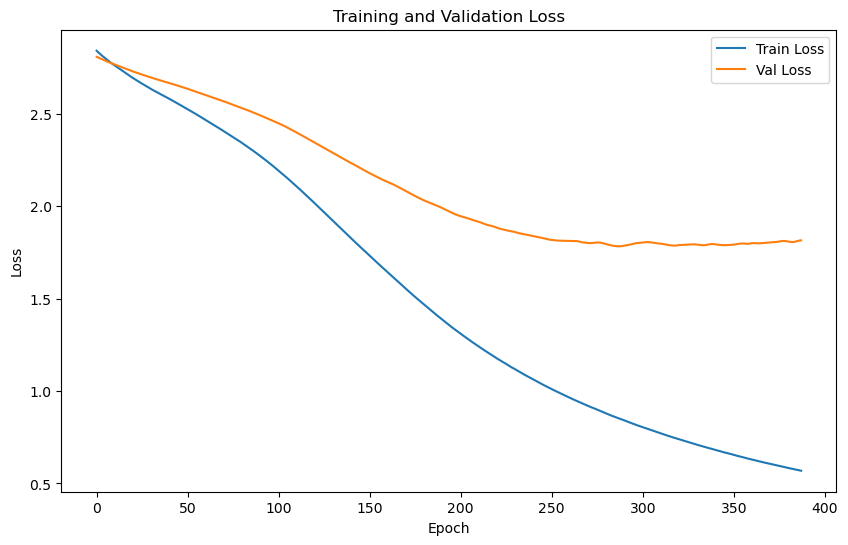

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.9328 | Test Accuracy: 33.10%


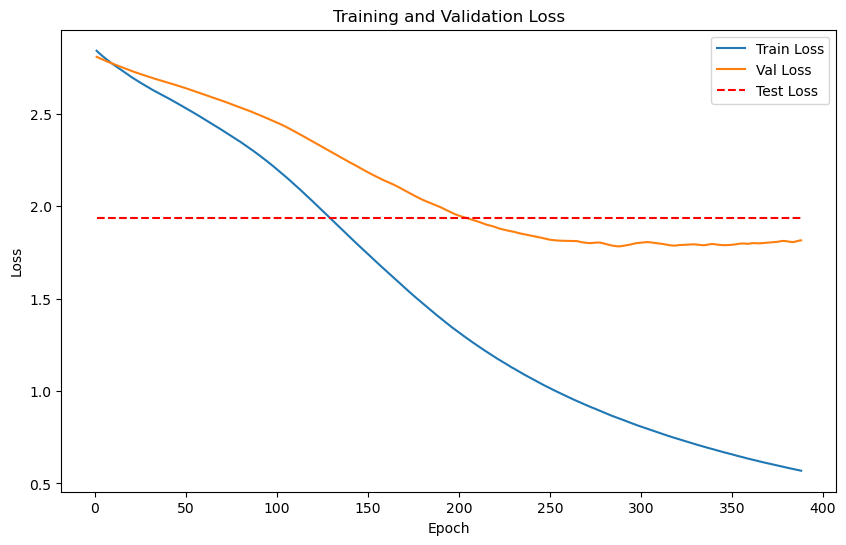

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


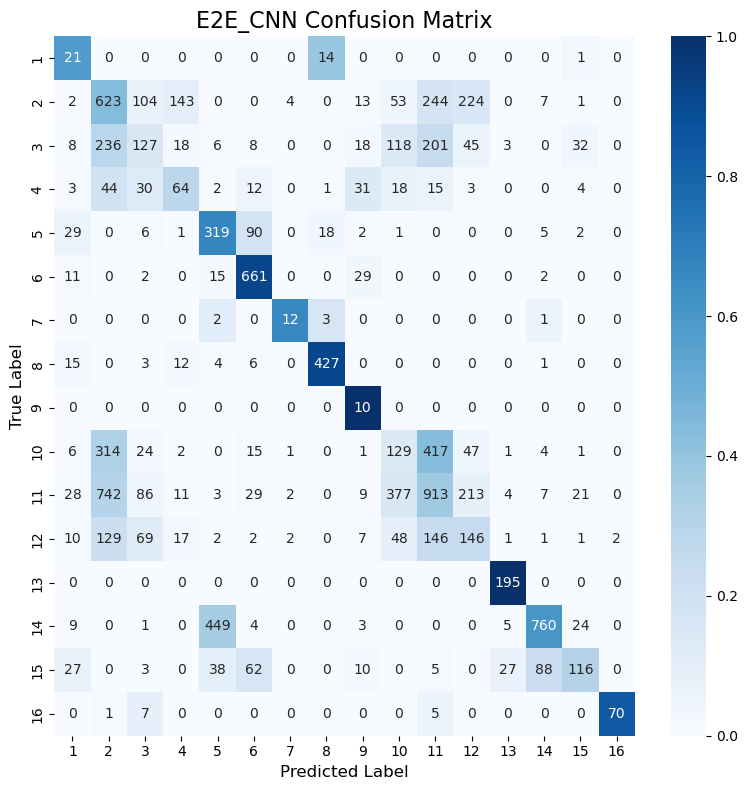

Classification Accuracy: 45.52%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


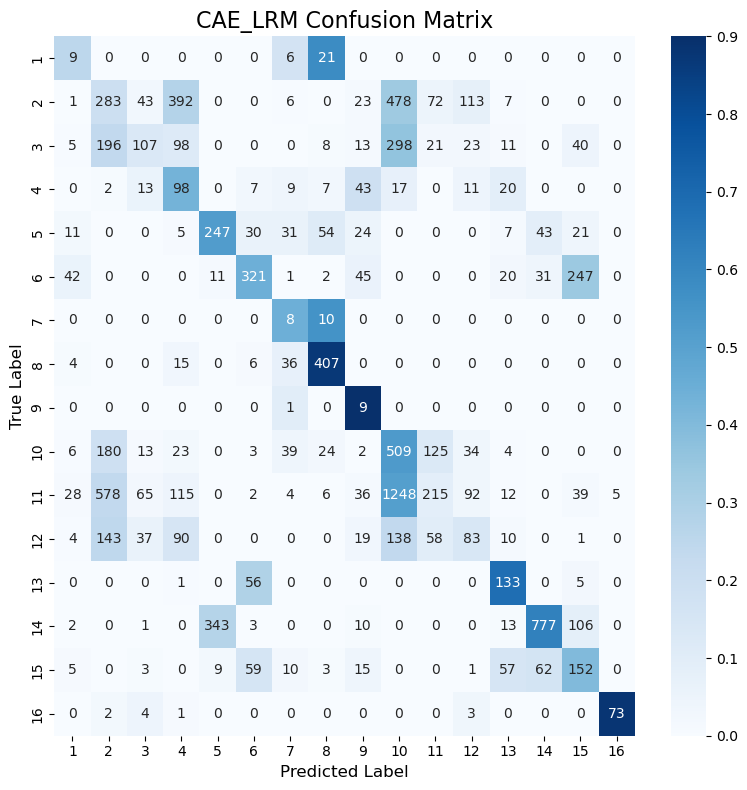

Classification Accuracy: 34.01%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


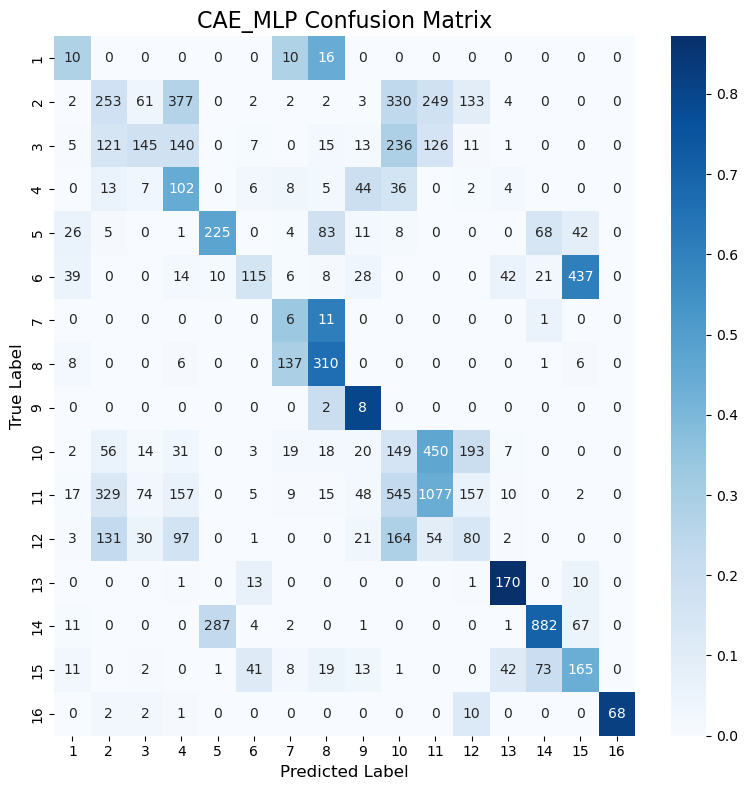

Classification Accuracy: 37.32%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


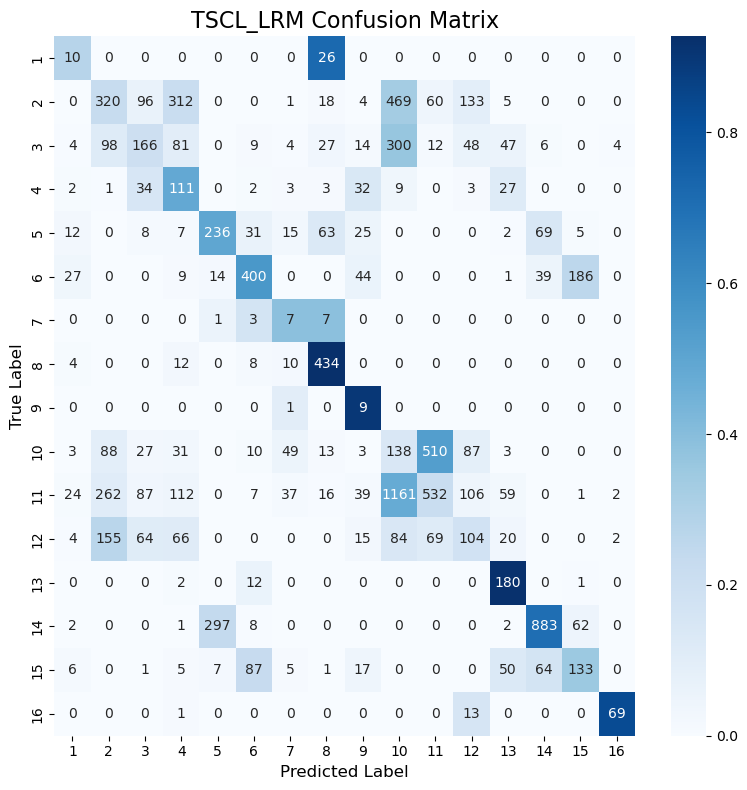

Classification Accuracy: 36.99%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


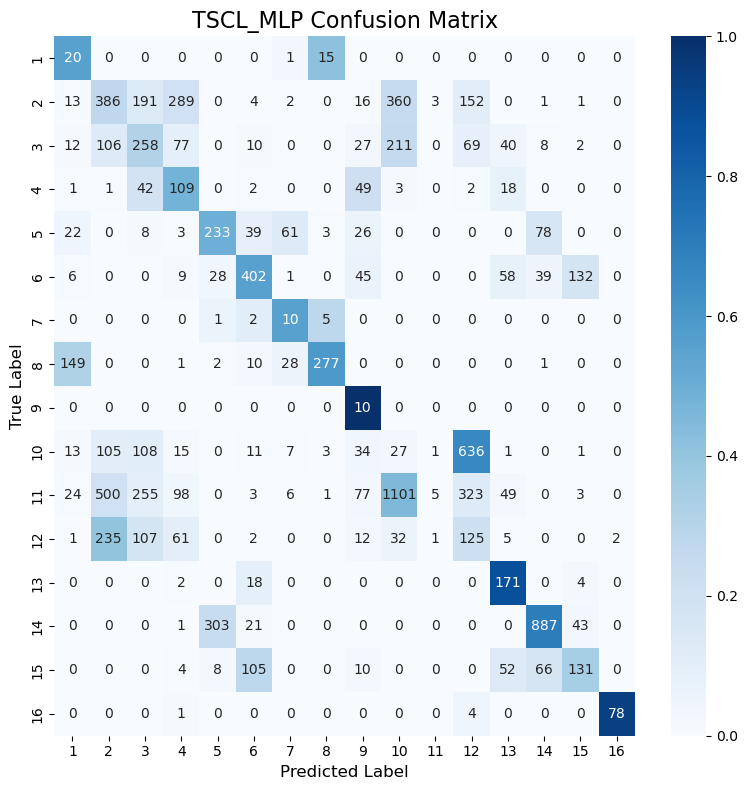

Classification Accuracy: 31.01%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


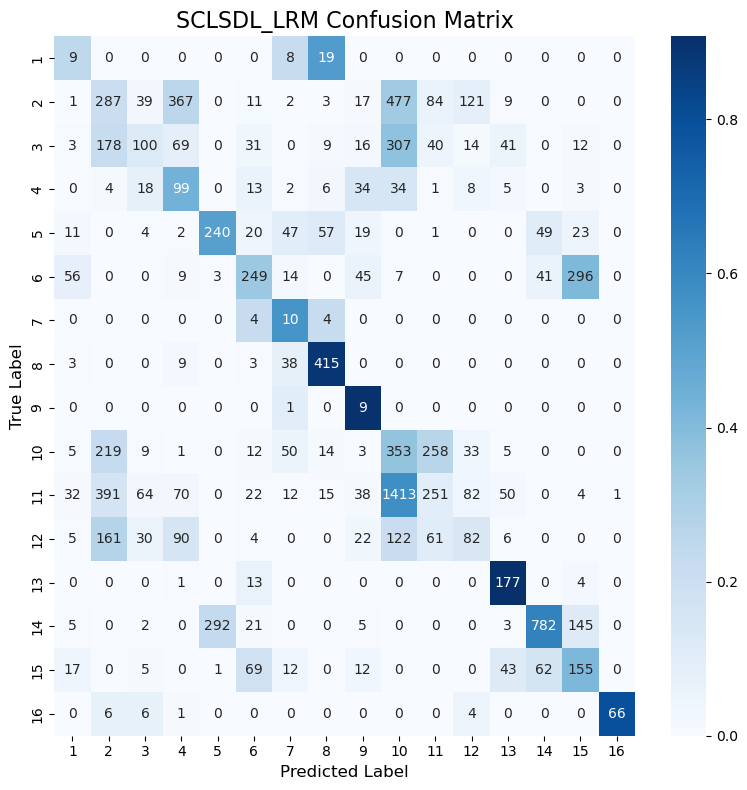

Classification Accuracy: 32.55%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


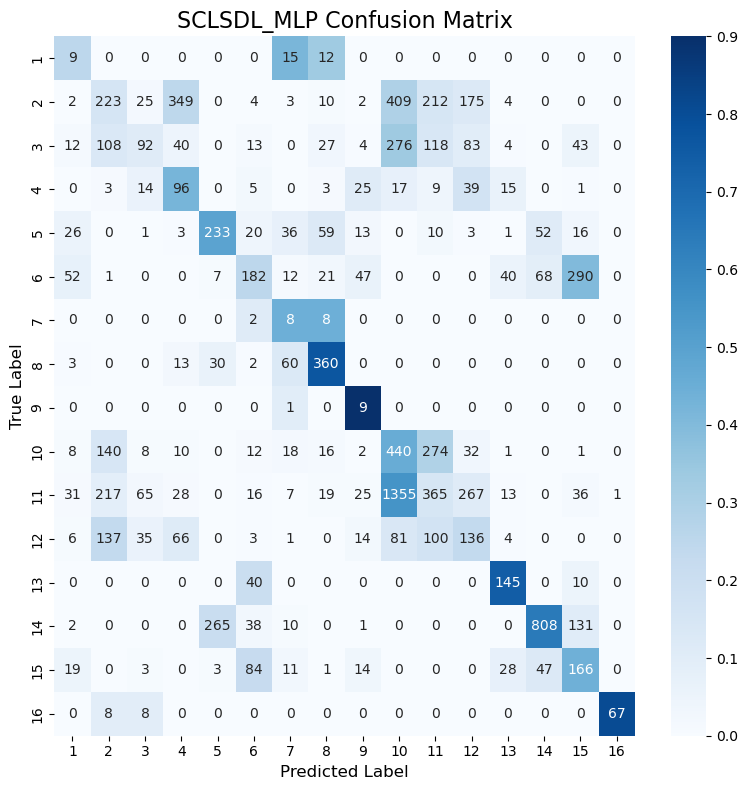

Classification Accuracy: 33.10%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          45.52
1    LRM (CAE)          34.01
2    MLP (CAE)          37.32
3     TSCL LRM          36.99
4     TSCL MLP          31.01
5  SCL_SDL LRM          32.55
6  SCL_SDL MLP          33.10

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          45.52
2    MLP (CAE)          37.32
3     TSCL LRM          36.99
1    LRM (CAE)          34.01
6  SCL_SDL MLP          33.10
5  SCL_SDL LRM          32.55
4     TSCL MLP          31.01
